In [2]:
!uv add pandas numpy matplotlib seaborn pyarrow

Resolved 51 packages in 6ms
Audited 16 packages in 0.01ms


In [3]:
import os
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
plt.rcParams['figure.dpi'] = 300
# Increase font sizes
plt.rcParams['font.size'] = 14  # Base font size
plt.rcParams['axes.titlesize'] = 16  # Axes title size
plt.rcParams['axes.labelsize'] = 14  # X and Y labels size
plt.rcParams['xtick.labelsize'] = 12  # X tick labels size
plt.rcParams['ytick.labelsize'] = 12  # Y tick labels size
plt.rcParams['legend.fontsize'] = 12  # Legend font size
plt.rcParams['figure.titlesize'] = 16 # Figure title size (suptitle)
plt.rcParams['axes.axisbelow'] = True

In [5]:
echo_logs = pd.read_parquet('echo_logs.parquet')
print(echo_logs.head())
print(echo_logs.info())

   log_type           filename   mode  clients  target_rate_client_hz  \
0  baseline  open_5c_1500p.log   open        5                 1500.0   
1  baseline  open_5c_2000p.log   open        5                 2000.0   
2  baseline     closed_16c.log  close       16                    NaN   
3  baseline  open_5c_8000p.log   open        5                 8000.0   
4  baseline  open_5c_5000p.log   open        5                 5000.0   

   target_rate_total_hz  total_requests  duration_sec  throughput_rps  \
0                7500.0           75304            10          7530.4   
1               10000.0          100303            10         10030.3   
2                   NaN          634515            10         63451.5   
3               40000.0          398605            10         39860.5   
4               25000.0          250692            10         25069.2   

   latency_avg_us  latency_p50_us  latency_p90_us  latency_p95_us  \
0         125.367             124             157    

# Plotting

In [6]:
close_loop_logs = echo_logs[echo_logs['mode'] == "close"]
close_loop_logs = close_loop_logs[close_loop_logs['clients'] < 64]
close_loop_logs

,log_type,filename,mode,clients,target_rate_client_hz,target_rate_total_hz,total_requests,duration_sec,throughput_rps,latency_avg_us,latency_p50_us,latency_p90_us,latency_p95_us,latency_p99_us
2,baseline,closed_16c.log,close,16,NaN,NaN,634515,10,63451.5,253.5630,250,288,302,337
10,baseline,closed_2c.log,close,2,NaN,NaN,229466,10,22946.6,86.5831,85,95,98,109
14,baseline,closed_32c.log,close,32,NaN,NaN,673407,10,67340.7,482.3720,481,548,576,651
15,baseline,closed_4c.log,close,4,NaN,NaN,351621,10,35162.1,113.3520,112,131,137,148
26,baseline,closed_8c.log,close,8,NaN,NaN,503969,10,50396.9,158.7240,156,182,193,225
36,cvm,closed_16c.log,close,16,NaN,NaN,571839,10,57183.9,281.4540,277,332,354,408
45,cvm,closed_2c.log,close,2,NaN,NaN,200056,10,20005.6,99.4397,99,106,112,125
50,cvm,closed_32c.log,close,32,NaN,NaN,683645,10,68364.5,475.1210,473,560,591,657
51,cvm,closed_4c.log,close,4,NaN,NaN,315034,10,31503.4,126.6210,126,145,149,159
59,cvm,closed_8c.log,close,8,NaN,NaN,436030,10,43603.0,183.5480,181,214,227,255


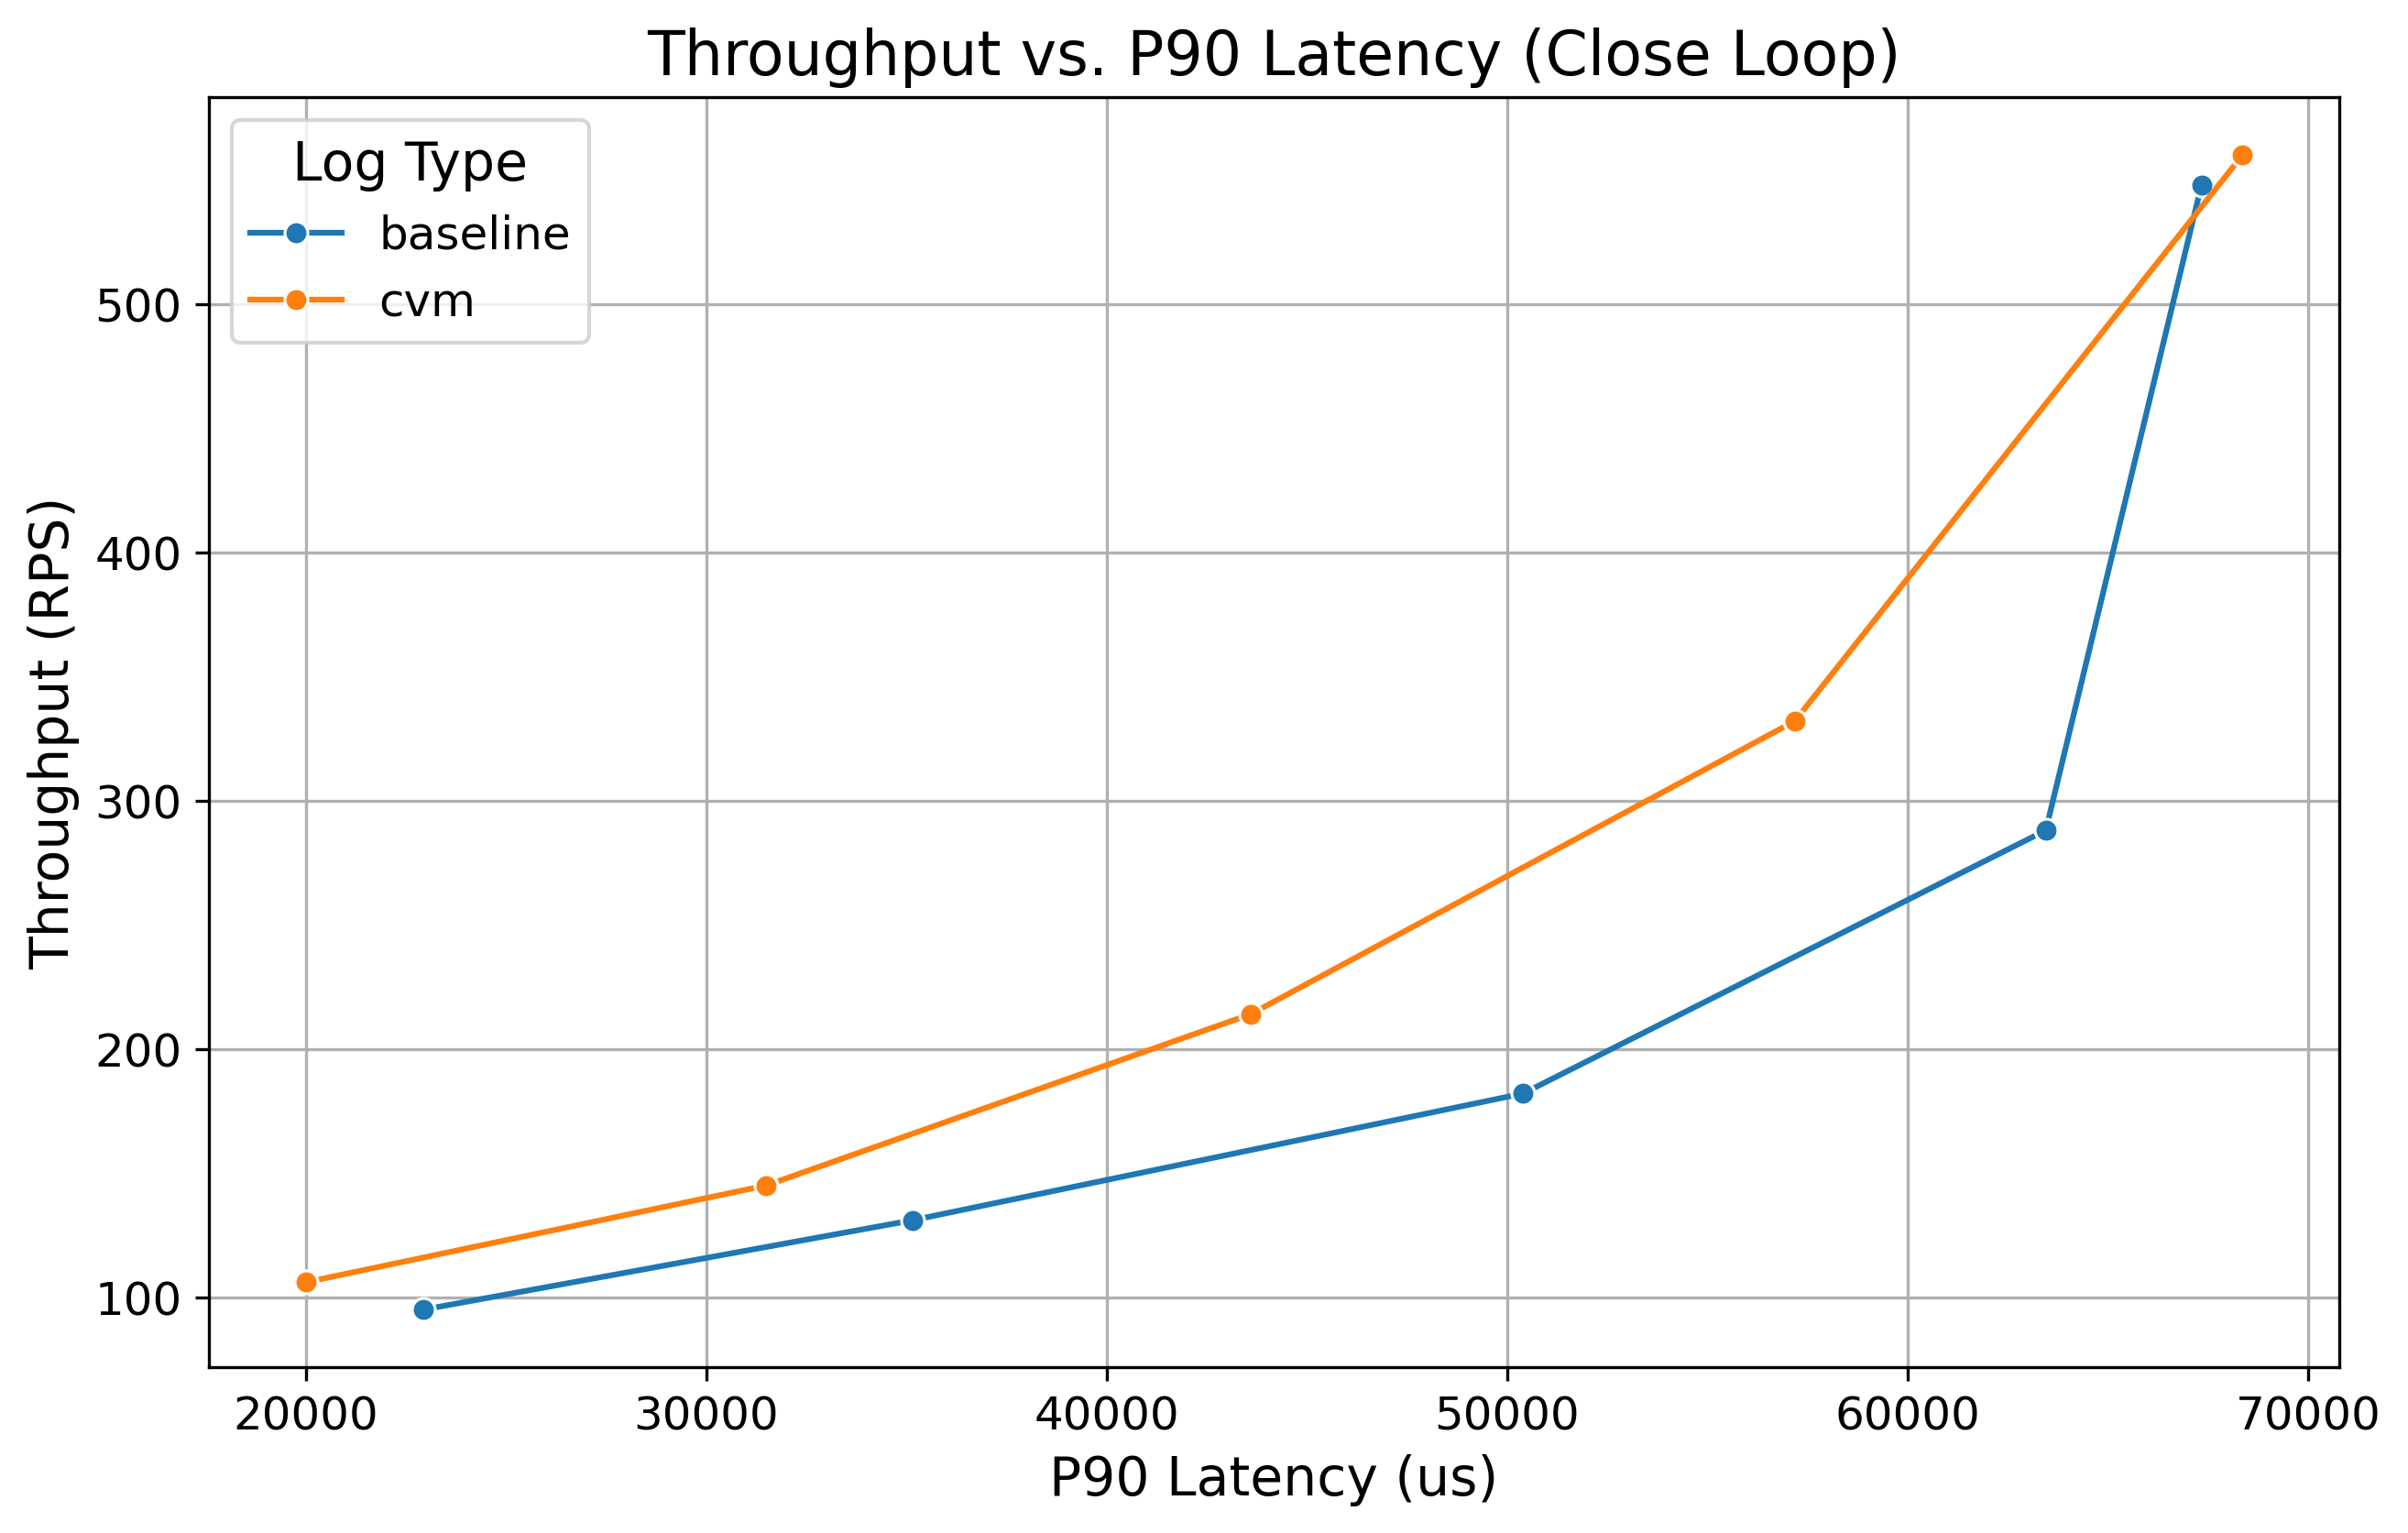

In [7]:
plt.figure(figsize=(10, 6))
# sns.lineplot(data=close_loop_logs, x='latency_p90_us', y='throughput_rps', hue='log_type', marker='o')
sns.lineplot(data=close_loop_logs, x='throughput_rps', y='latency_p90_us', hue='log_type', marker='o')
plt.title('Throughput vs. P90 Latency (Close Loop)')
plt.xlabel('P90 Latency (us)')
plt.ylabel('Throughput (RPS)')
plt.grid(True)
plt.legend(title='Log Type')
plt.show()

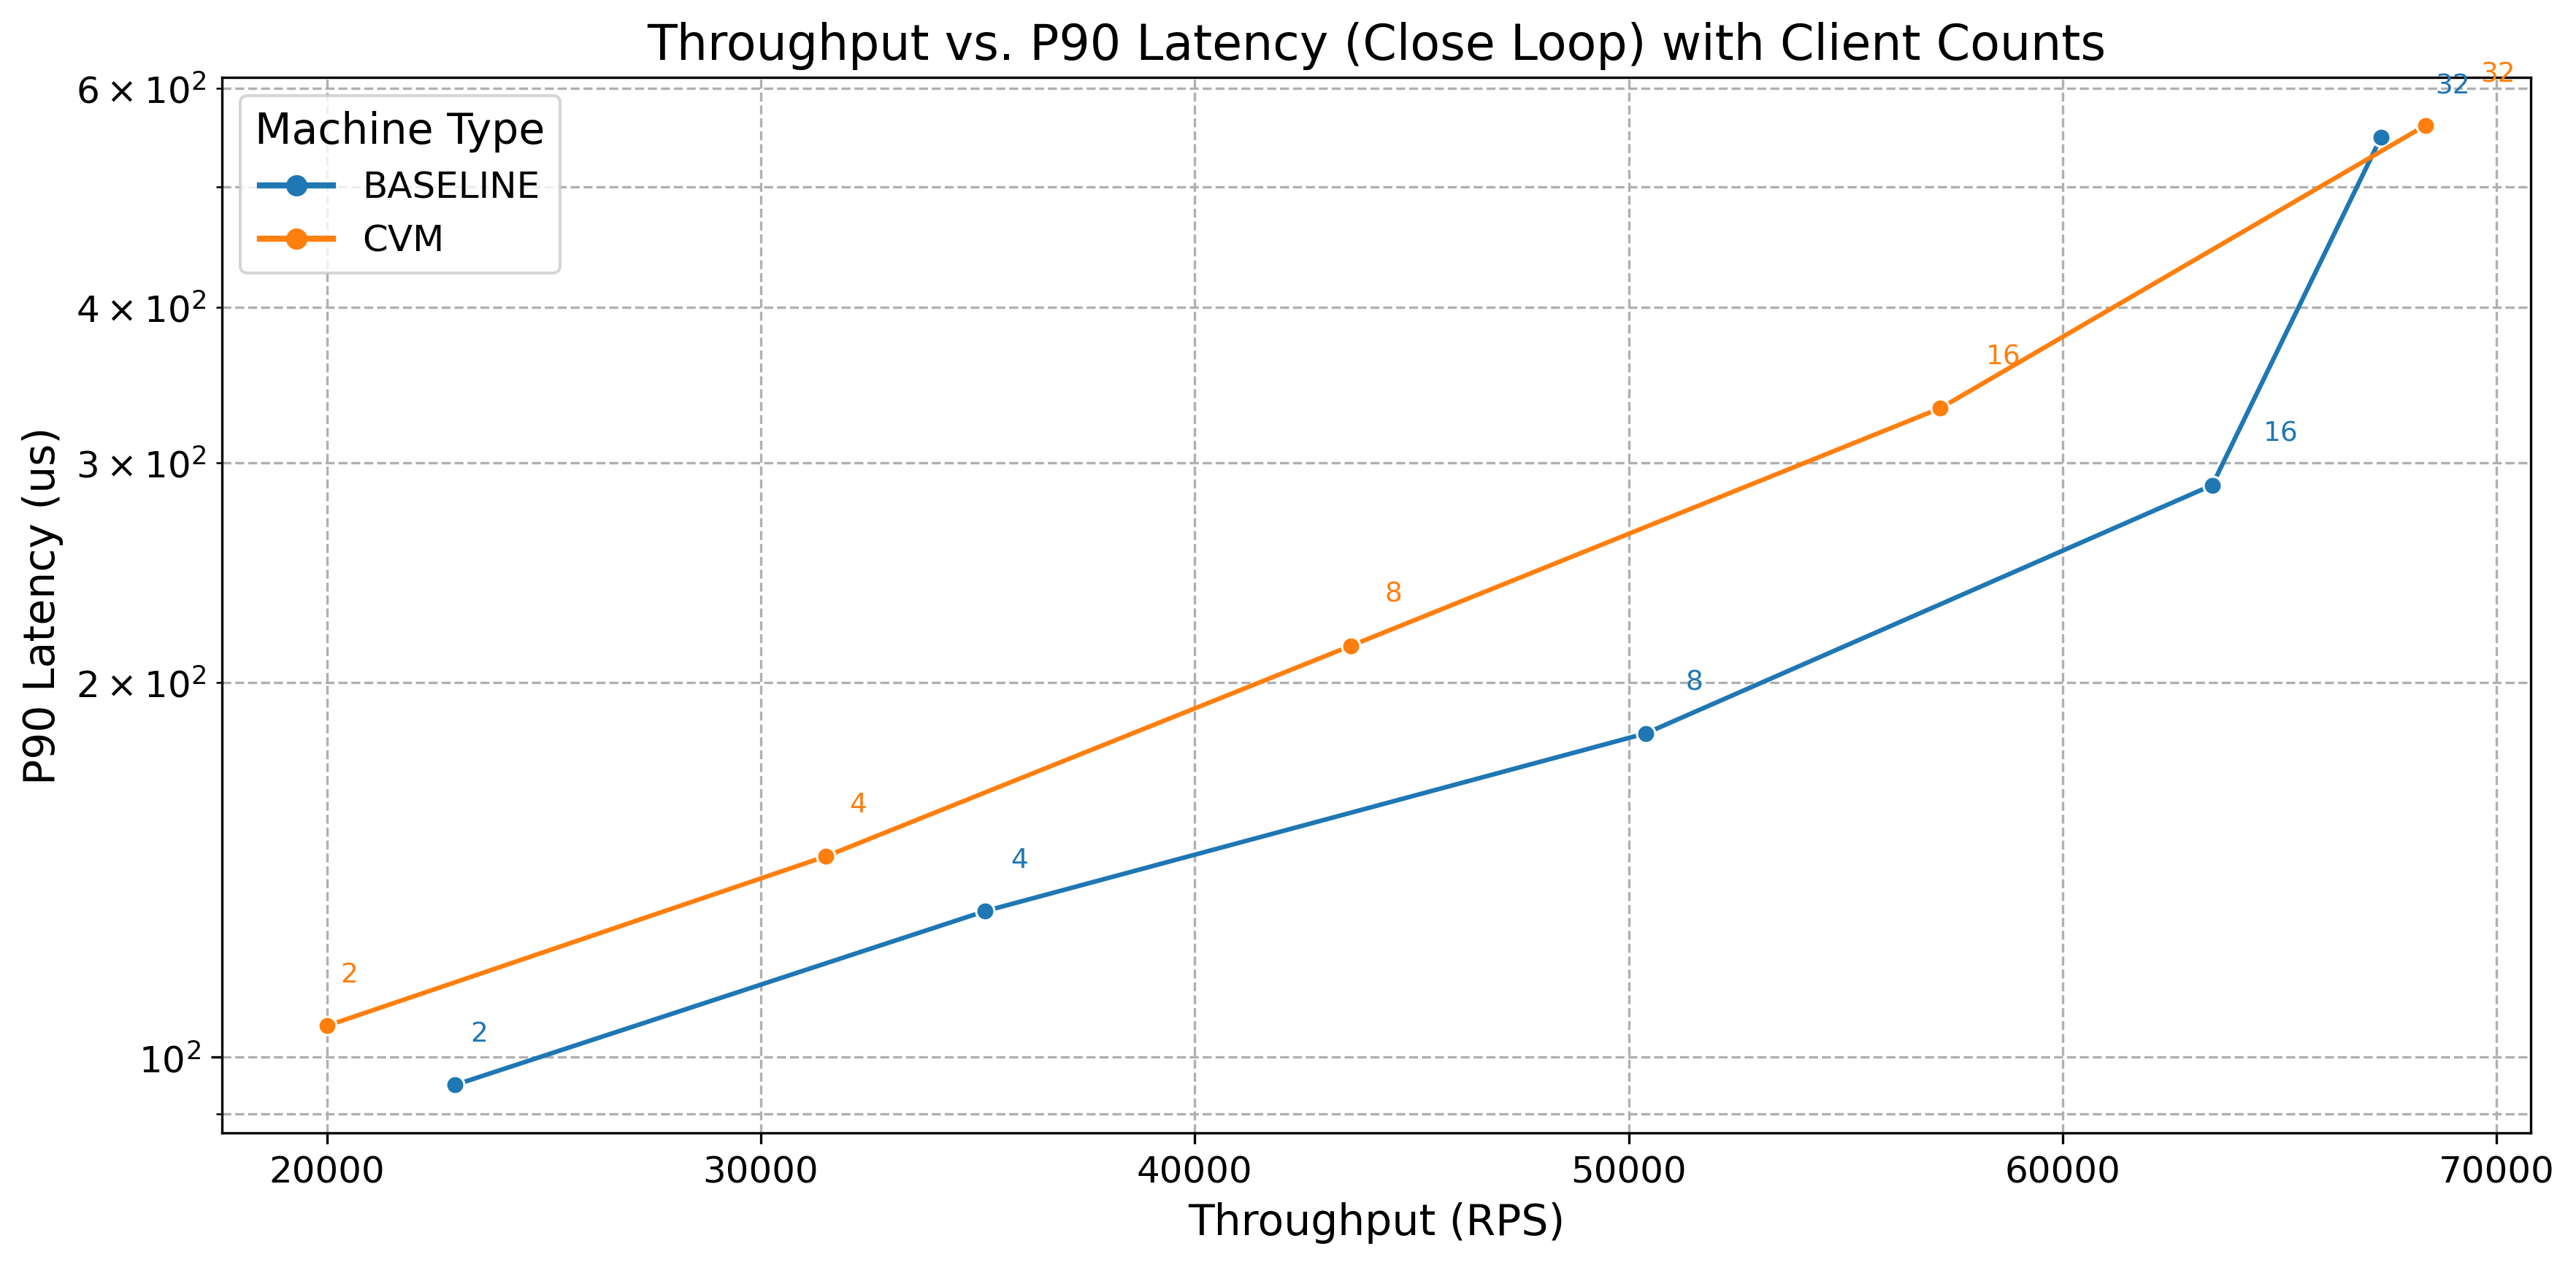

In [8]:
plt.figure(figsize=(12, 6)) 
# Plot the lines first
sns.lineplot(data=close_loop_logs, x='throughput_rps', y='latency_p90_us', hue='log_type', marker='o', legend=False) # Turn off default legend for lines

# Get the color palette used by seaborn
unique_log_types = close_loop_logs['log_type'].unique()
colors = sns.color_palette(n_colors=len(unique_log_types))
log_type_to_color = dict(zip(unique_log_types, colors))

# Add annotations
# Iterate through each point in the dataframe to add text
for i in range(close_loop_logs.shape[0]):
    point_log_type = close_loop_logs['log_type'].iloc[i]
    point_color = log_type_to_color[point_log_type]
    plt.text(close_loop_logs['throughput_rps'].iloc[i] * 1.02 - 100, # x coordinate offset further to the right
             close_loop_logs['latency_p90_us'].iloc[i] * 1.1, # y coordinate
             str(close_loop_logs['clients'].iloc[i]), # the text label (clients)
             fontdict=dict(color=point_color, size=9), # Use corresponding color for text
             ha='left', # Horizontal alignment
             va='center') # Vertical alignment

plt.title('Throughput vs. P90 Latency (Close Loop) with Client Counts')
plt.xlabel('Throughput (RPS)') # Corrected label based on plot data
plt.ylabel('P90 Latency (us)') # Corrected label based on plot data
plt.yscale('log') # Set y-axis to log scale
plt.grid(True, which="both", ls="--") # Added grid options for log scale

# Create a custom legend for log_type
# Use the colors derived earlier
custom_handles = [plt.Line2D([0], [0], color=log_type_to_color[log_type], lw=2, marker='o') for log_type in unique_log_types]
plt.legend(custom_handles, unique_log_types, title='Machine Type')
# Get the current legend object
legend = plt.gca().get_legend()
# Define the new labels based on the unique types, capitalized
new_labels = [l.upper() for l in unique_log_types]
# Update the legend texts
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)

plt.tight_layout() # Adjust layout to prevent labels overlapping figure edge
plt.show()

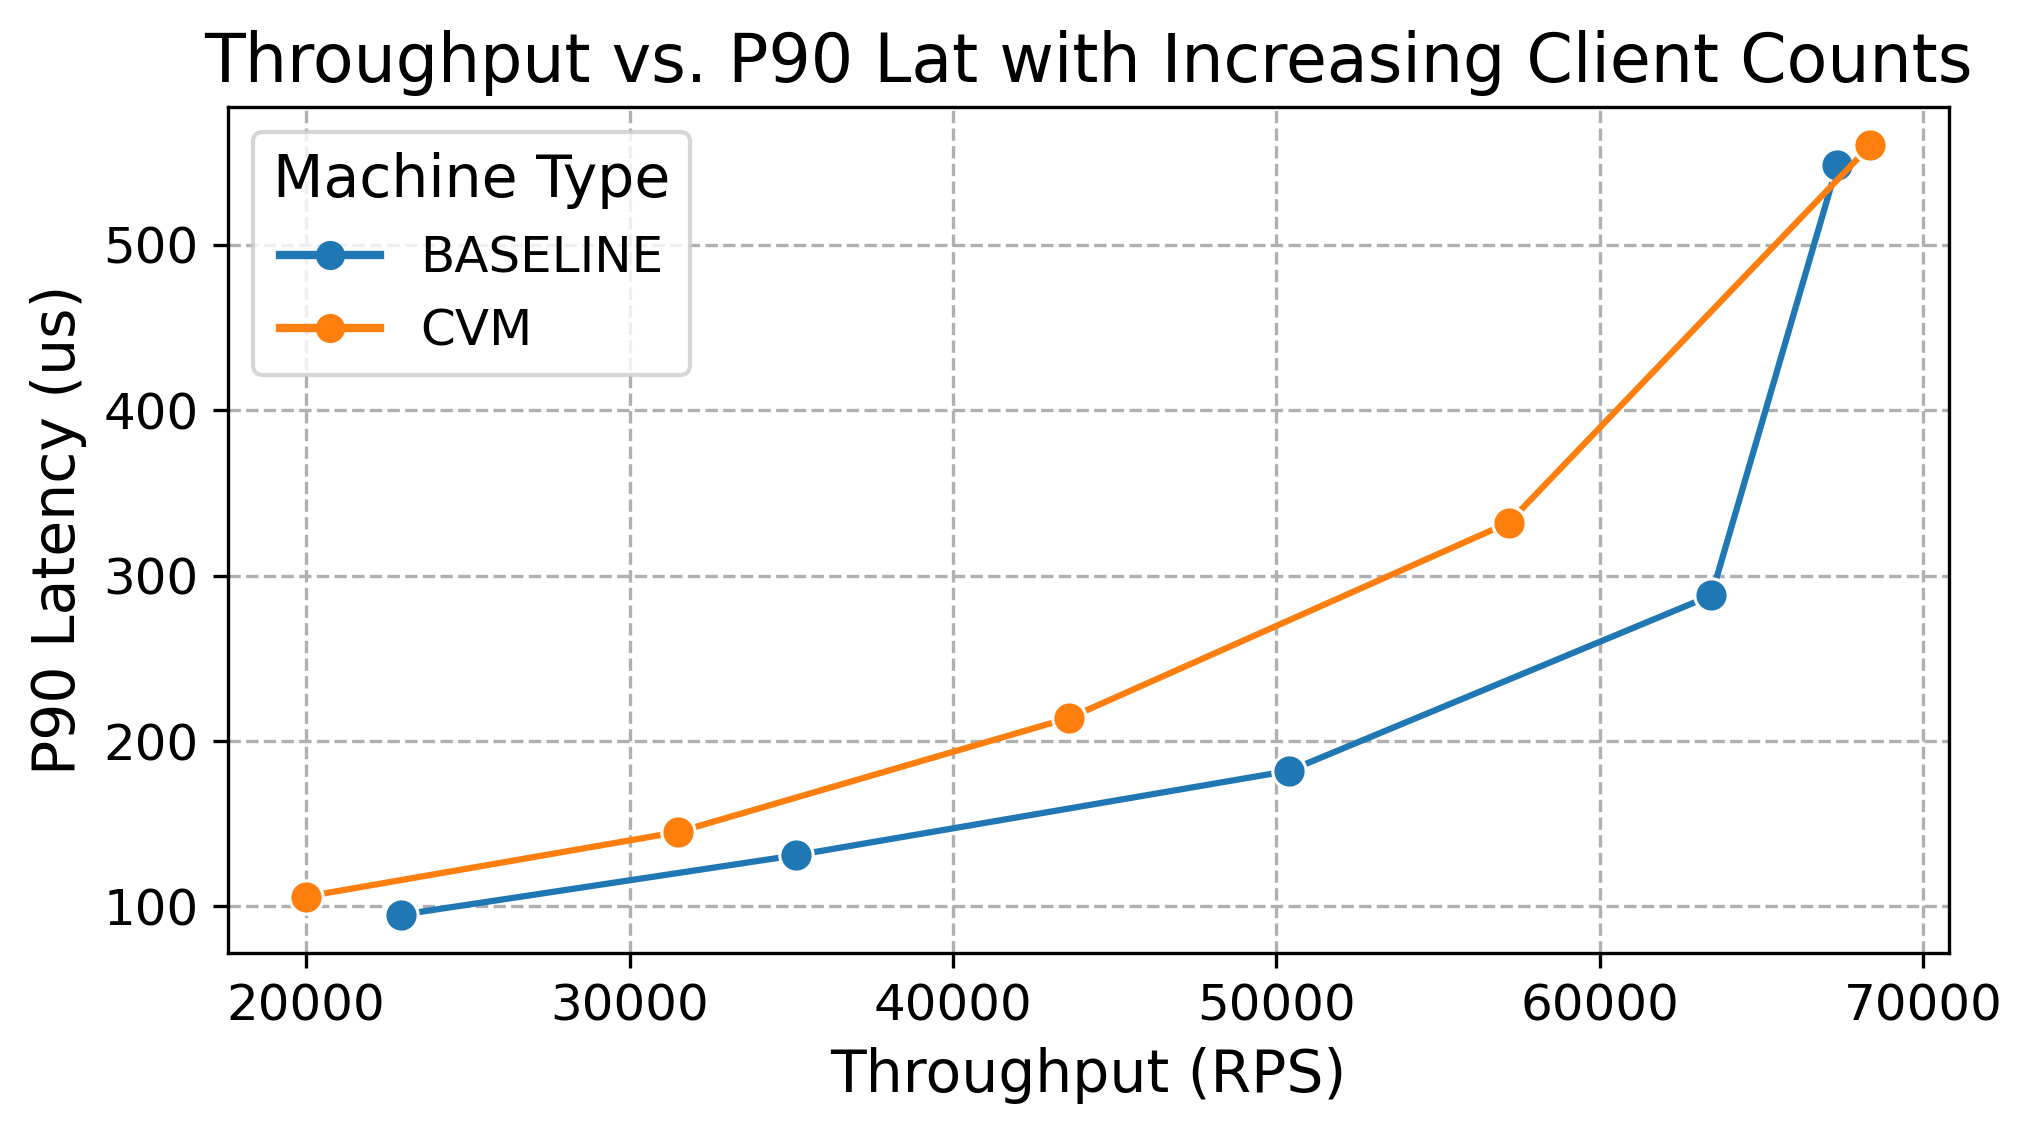

In [9]:
plt.figure(figsize=(7, 4)) 
# Plot the lines first
# sns.lineplot(data=close_loop_logs, x='throughput_rps', y='latency_p90_us', hue='log_type', marker='o', legend=False) # Turn off default legend for lines
sns.lineplot(data=close_loop_logs, x='throughput_rps', y='latency_p90_us', hue='log_type', marker='o', legend=False, linewidth=1.5, markersize=8)


# Get the color palette used by seaborn
unique_log_types = close_loop_logs['log_type'].unique()
colors = sns.color_palette(n_colors=len(unique_log_types))
log_type_to_color = dict(zip(unique_log_types, colors))

plt.title('Throughput vs. P90 Lat with Increasing Client Counts')
plt.xlabel('Throughput (RPS)') # Corrected label based on plot data
plt.ylabel('P90 Latency (us)') # Corrected label based on plot data
# plt.yscale('log') # Set y-axis to log scale
plt.grid(True, which="both", ls="--") # Added grid options for log scale

# Create a custom legend for log_type
# Use the colors derived earlier
custom_handles = [plt.Line2D([0], [0], color=log_type_to_color[log_type], lw=2, marker='o') for log_type in unique_log_types]
plt.legend(custom_handles, unique_log_types, title='Machine Type')
# Get the current legend object
legend = plt.gca().get_legend()
# Define the new labels based on the unique types, capitalized
new_labels = [l.upper() for l in unique_log_types]
# Update the legend texts
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)

plt.tight_layout() # Adjust layout to prevent labels overlapping figure edge
plt.show()

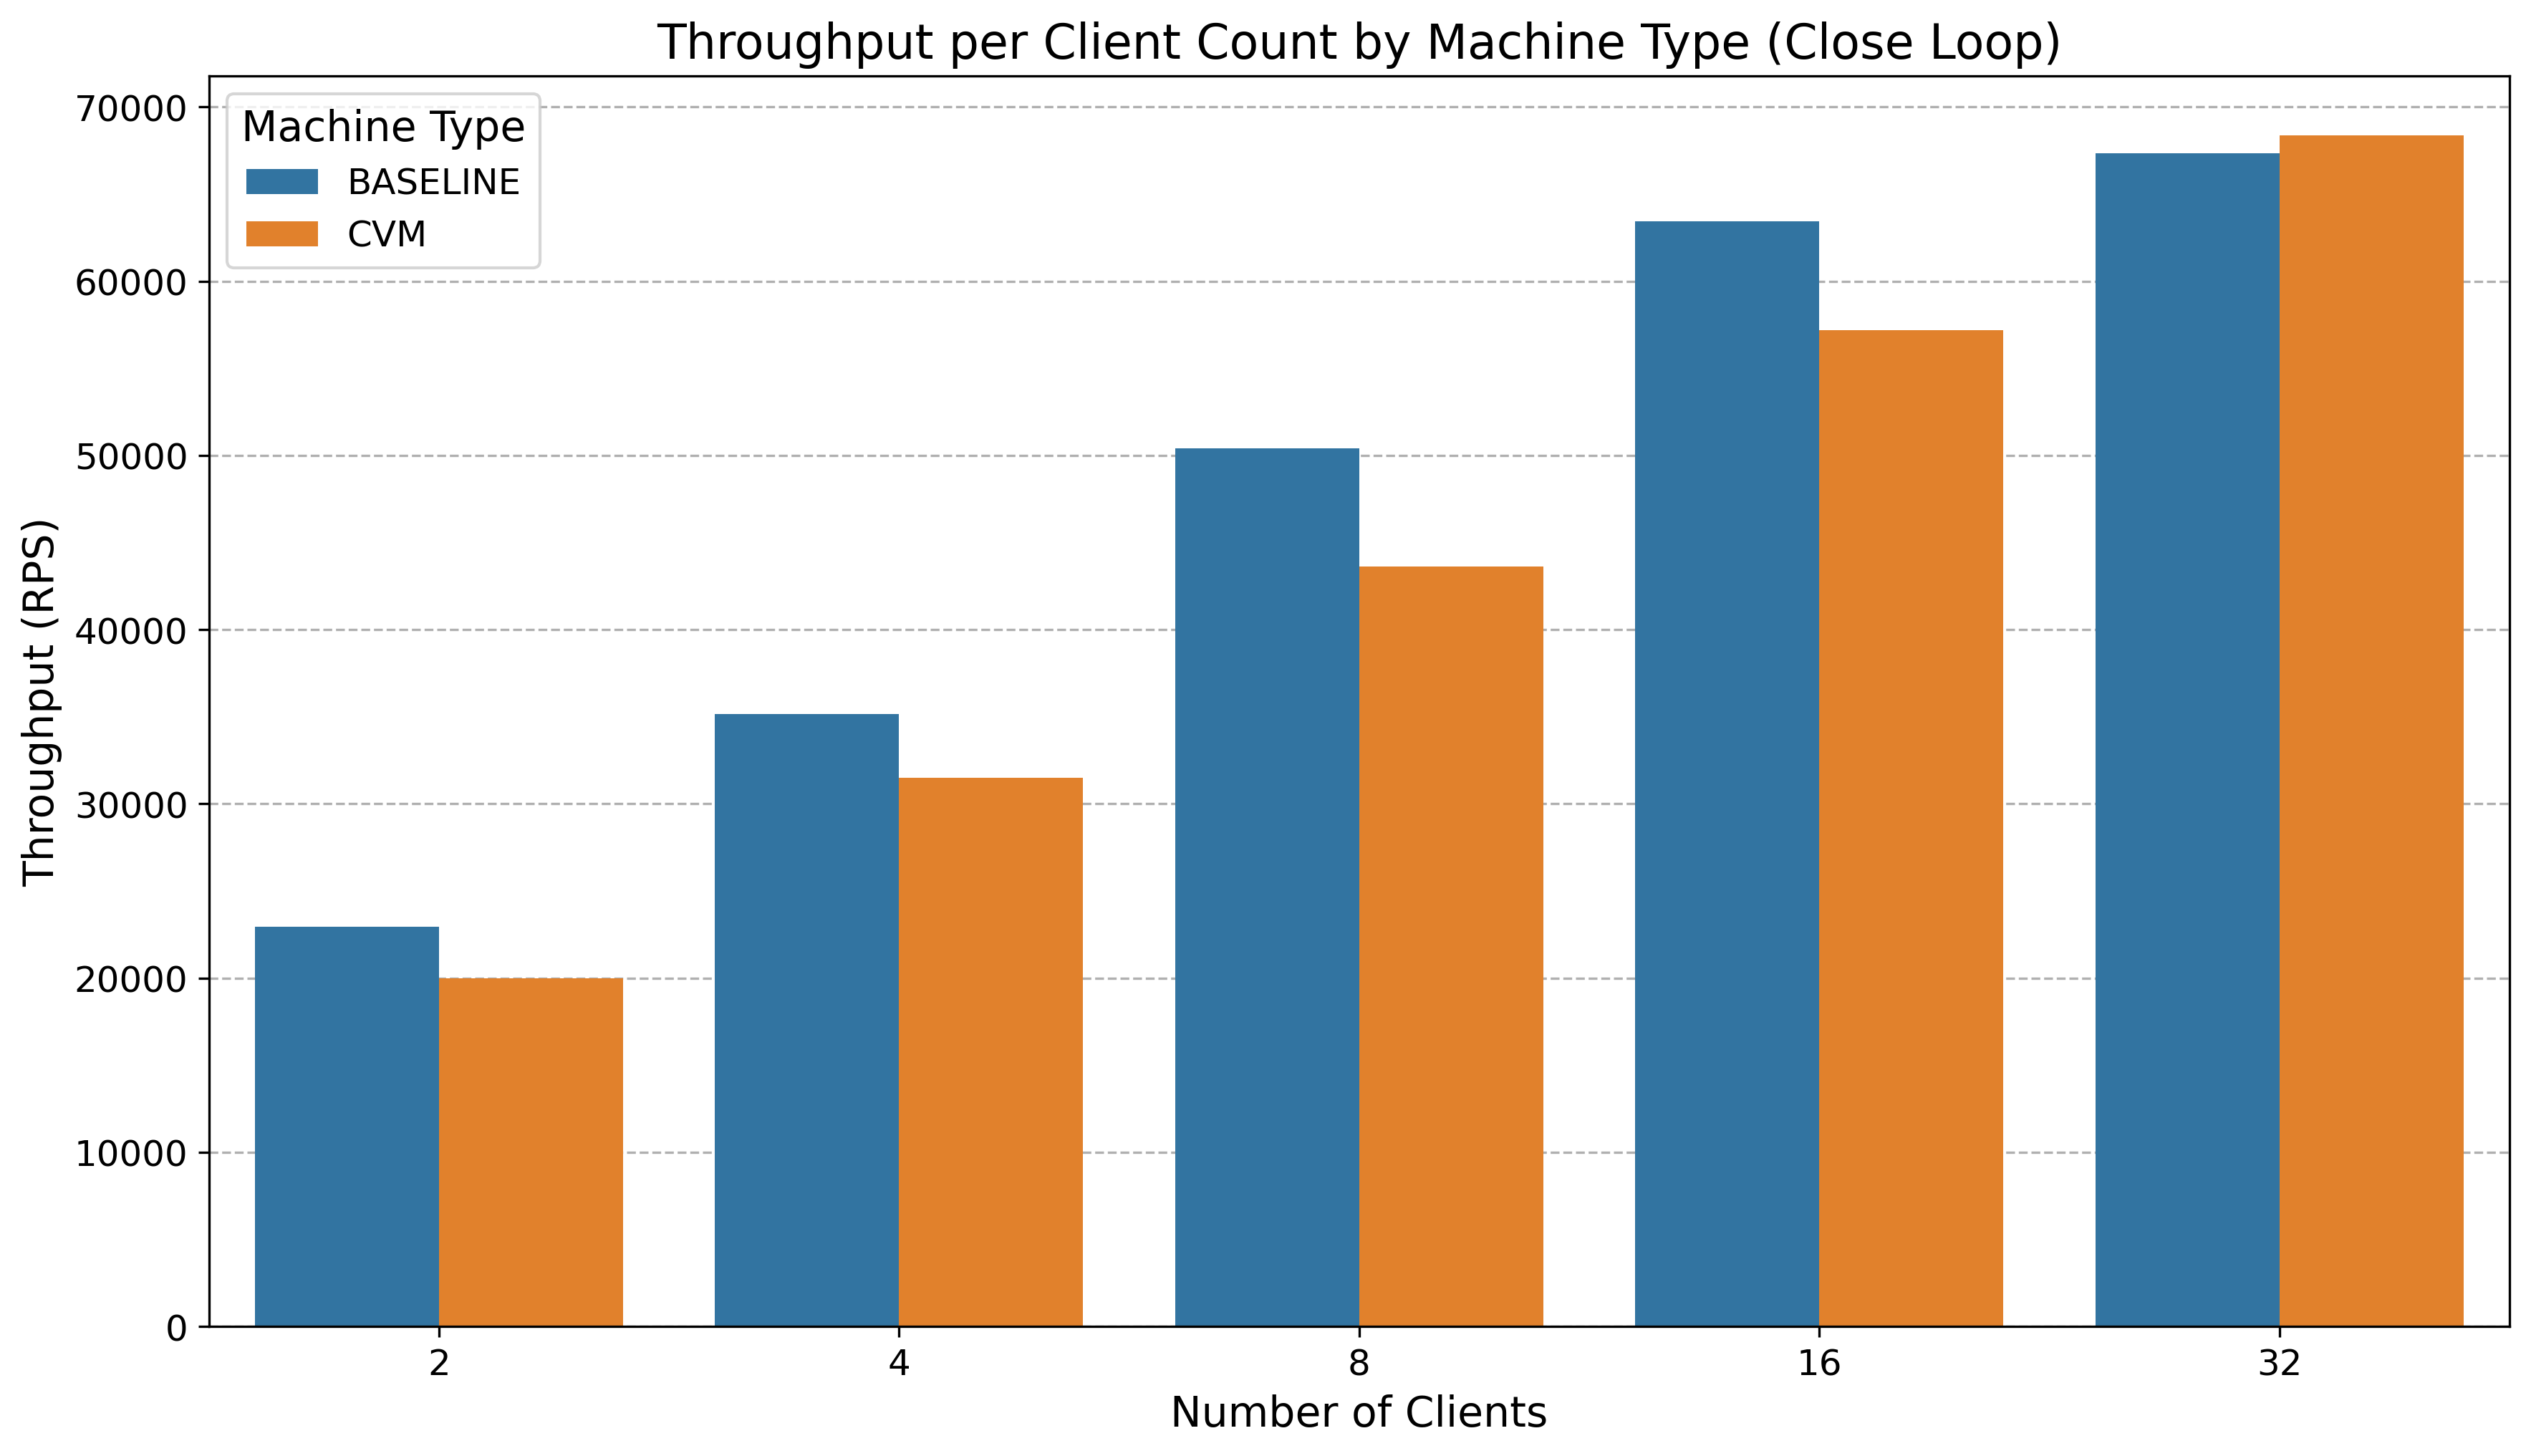

In [10]:
plt.figure(figsize=(12, 7))
sns.barplot(data=close_loop_logs, x='clients', y='throughput_rps', hue='log_type')

plt.title('Throughput per Client Count by Machine Type (Close Loop)')
plt.xlabel('Number of Clients')
plt.ylabel('Throughput (RPS)')
plt.grid(True, axis='y', linestyle='--')

# Get the current legend object
legend = plt.gca().get_legend()
# Define the new labels based on the unique types, capitalized
new_labels = [l.get_text().upper() for l in legend.get_texts()]
# Update the legend texts
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)
legend.set_title('Machine Type')


plt.tight_layout()
plt.show()

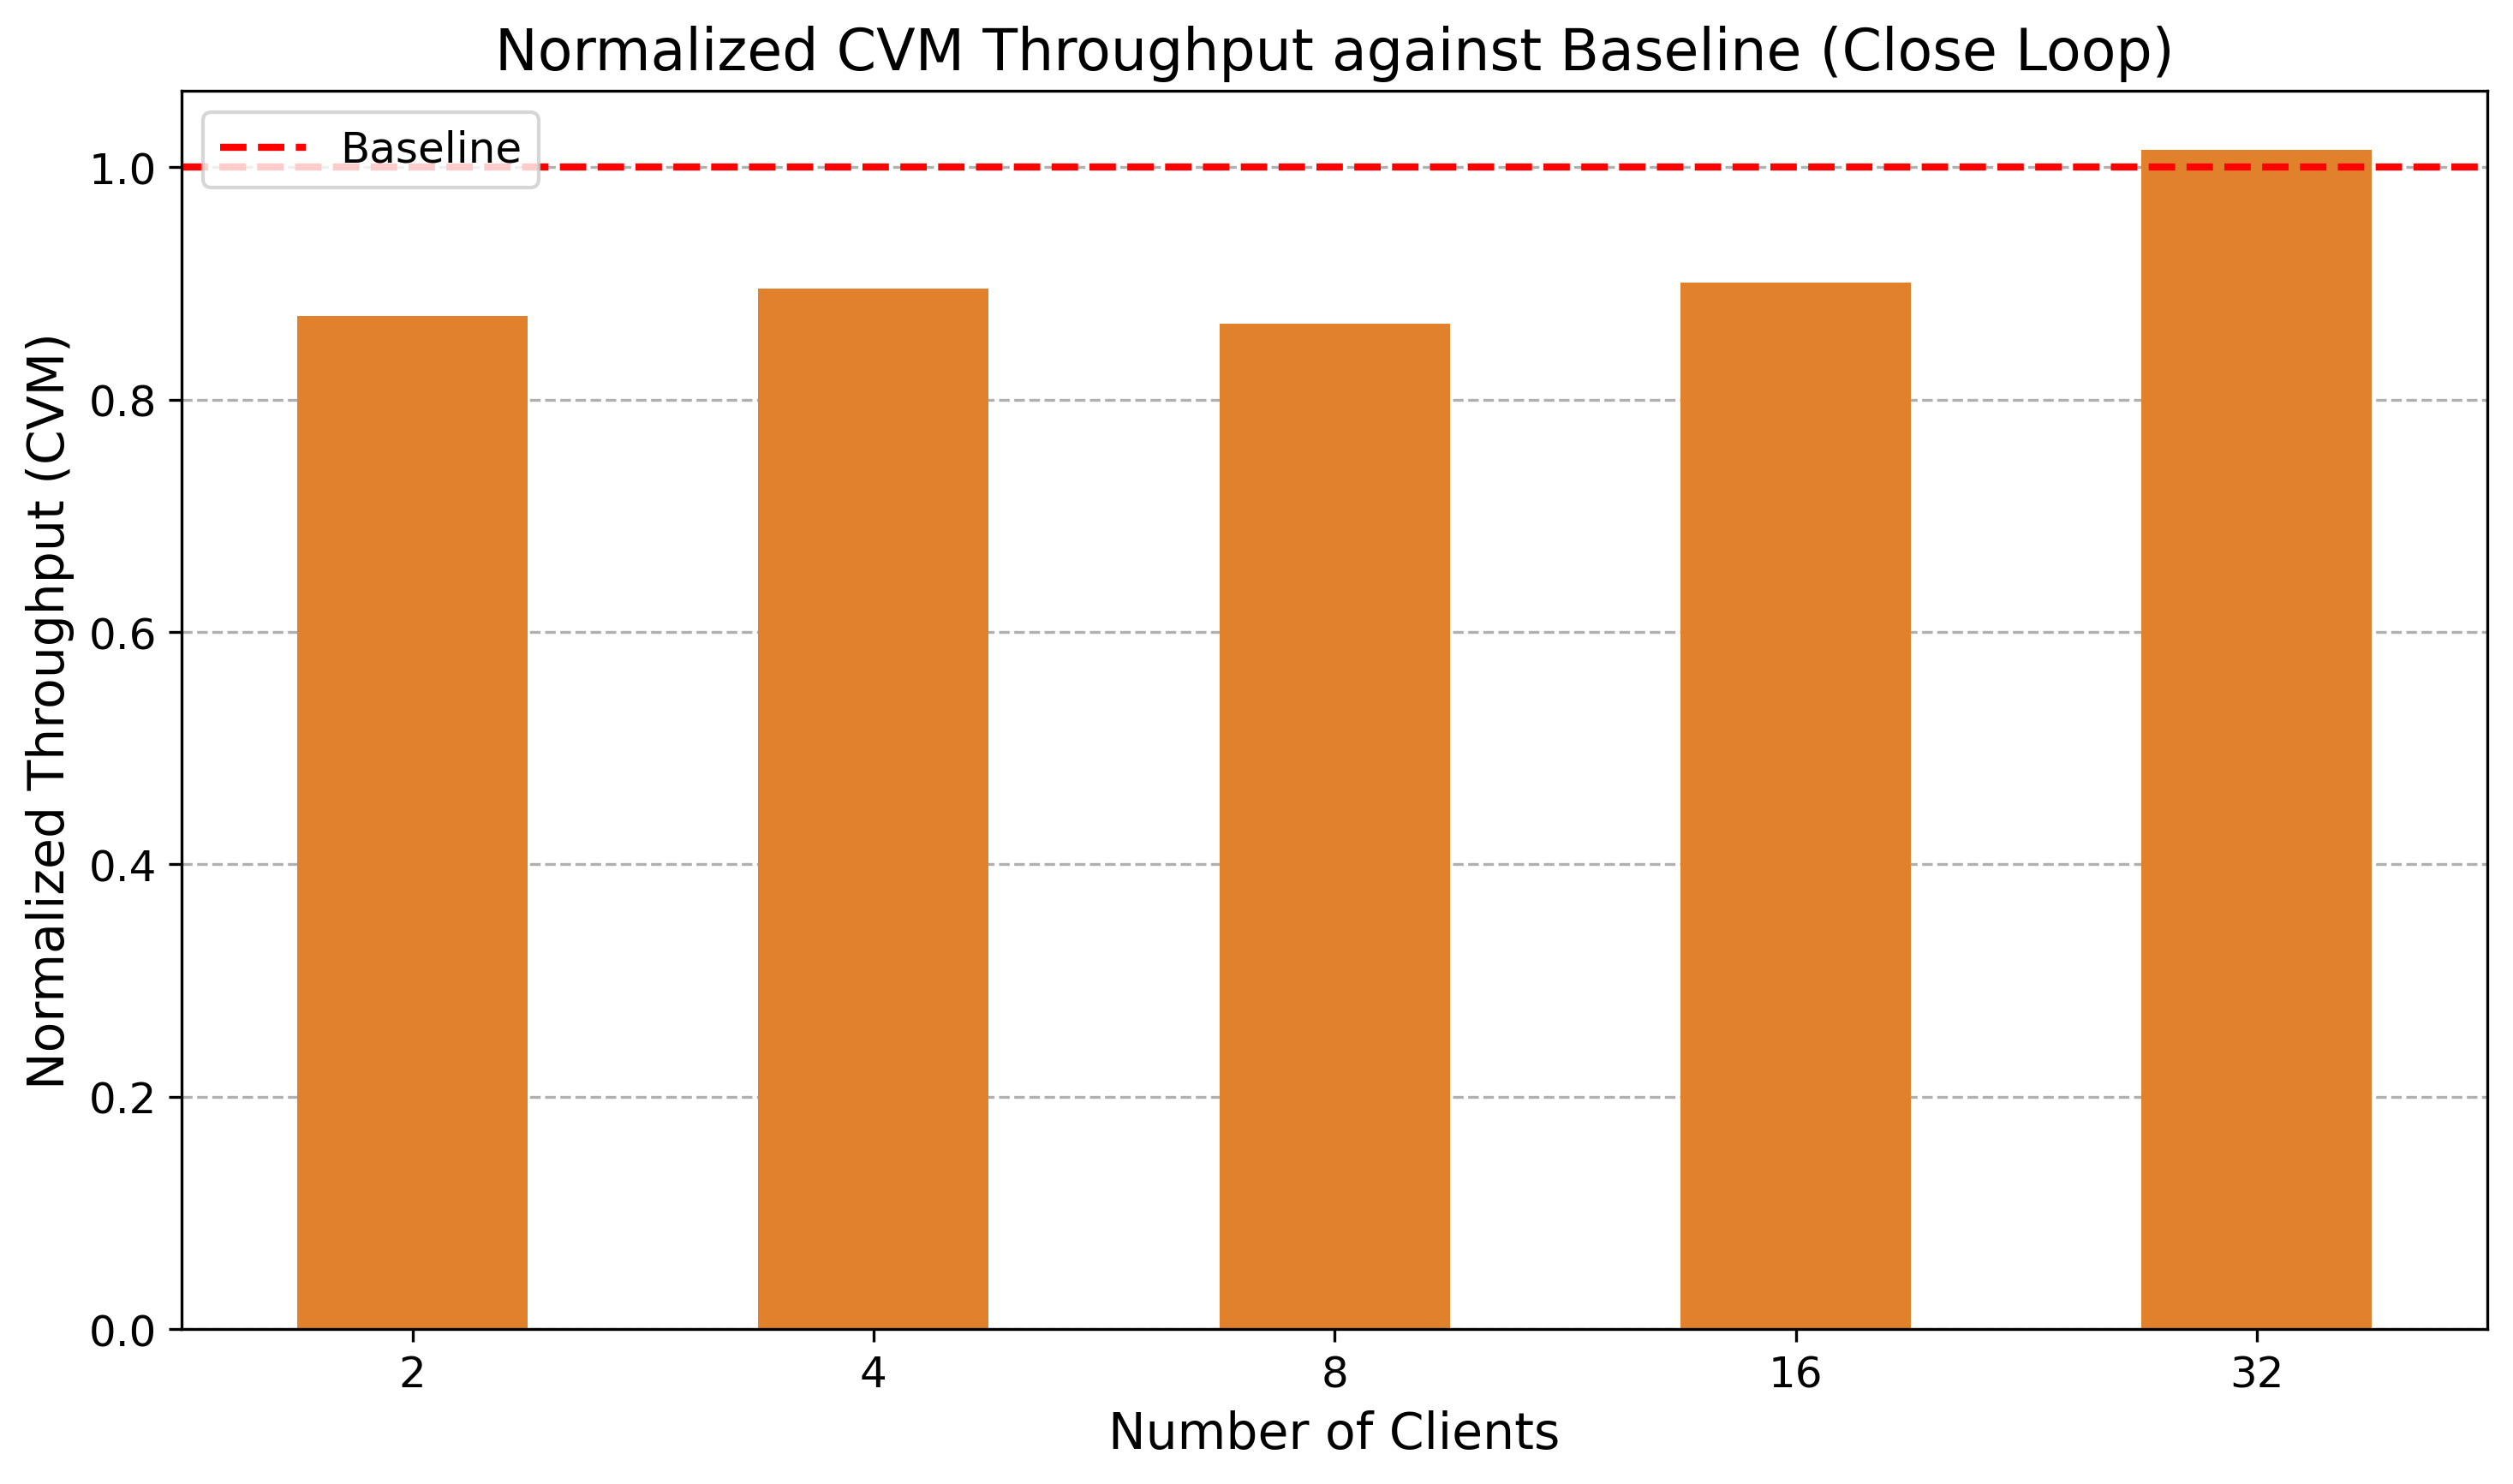

log_type  clients  normalized_throughput
0               2               0.871833
1               4               0.895948
2               8               0.865192
3              16               0.901222
4              32               1.015203


In [11]:
# Pivot the table to get baseline and cvm throughputs side-by-side for each client count
pivot_df = close_loop_logs.pivot(index='clients', columns='log_type', values='throughput_rps')

# Calculate the normalized throughput (CVM / Baseline)
# Ensure 'baseline' and 'cvm' columns exist after pivoting
if 'baseline' in pivot_df.columns and 'cvm' in pivot_df.columns:
    pivot_df['normalized_throughput'] = pivot_df['cvm'] / pivot_df['baseline']
else:
    print("Error: 'baseline' or 'cvm' log_type not found in the data.")
    # Handle the error appropriately, maybe skip plotting or raise an exception
    pivot_df['normalized_throughput'] = np.nan # Add column with NaNs if types missing

# Reset index to make 'clients' a column again for plotting
pivot_df = pivot_df.reset_index()

# Plotting the normalized throughput
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_df, x='clients', y='normalized_throughput', color=sns.color_palette()[1], width=0.5) # Use a single color

plt.title('Normalized CVM Throughput against Baseline (Close Loop)')
plt.xlabel('Number of Clients')
plt.ylabel('Normalized Throughput (CVM)')
plt.grid(True, axis='y', linestyle='--')
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()

plt.tight_layout()
plt.show()

print(pivot_df[['clients', 'normalized_throughput']])

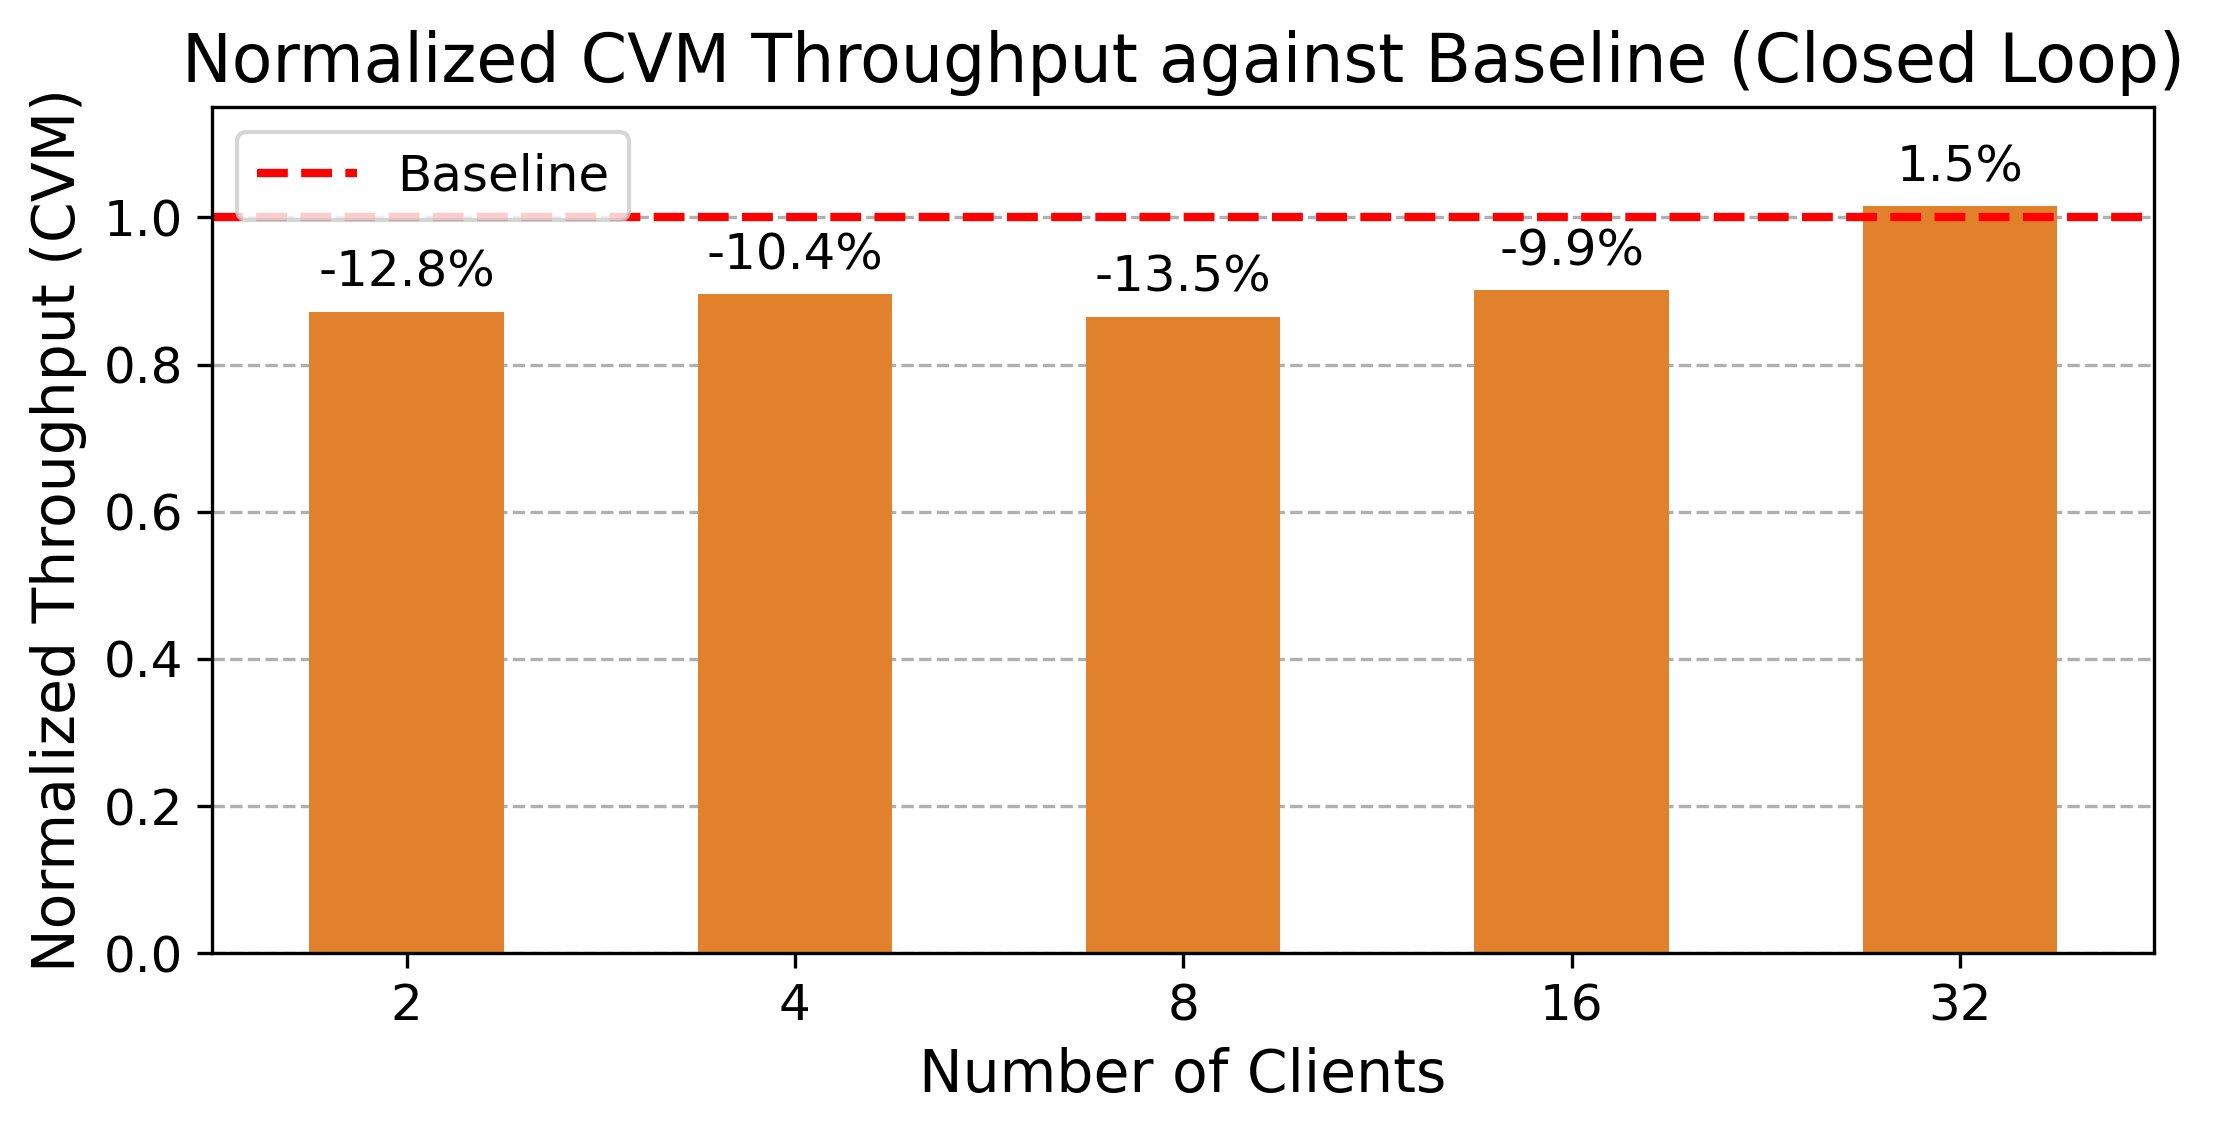

log_type  clients  normalized_throughput
0               2               0.871833
1               4               0.895948
2               8               0.865192
3              16               0.901222
4              32               1.015203


In [12]:
# Pivot the table to get baseline and cvm throughputs side-by-side for each client count
pivot_df = close_loop_logs.pivot(index='clients', columns='log_type', values='throughput_rps')

# Calculate the normalized throughput (CVM / Baseline)
# Ensure 'baseline' and 'cvm' columns exist after pivoting
if 'baseline' in pivot_df.columns and 'cvm' in pivot_df.columns:
    pivot_df['normalized_throughput'] = pivot_df['cvm'] / pivot_df['baseline']
else:
    print("Error: 'baseline' or 'cvm' log_type not found in the data.")
    # Handle the error appropriately, maybe skip plotting or raise an exception
    pivot_df['normalized_throughput'] = np.nan # Add column with NaNs if types missing

# Reset index to make 'clients' a column again for plotting
pivot_df = pivot_df.reset_index()

# Plotting the normalized throughput
plt.figure(figsize=(7.5, 4))
barplot = sns.barplot(data=pivot_df, x='clients', y='normalized_throughput', color=sns.color_palette()[1], width=0.5) # Use a single color

# Add text annotations for slowdown percentage
for index, row in pivot_df.iterrows():
    clients = row['clients']
    normalized_throughput = row['normalized_throughput']
    # Calculate slowdown percentage
    slowdown_pct = -(1 - normalized_throughput) * 100
    # Position the text slightly above the bar
    # Find the corresponding bar patch to get its x coordinate
    # Note: This assumes the order of bars matches the order in pivot_df
    bar_x_center = barplot.patches[index].get_x() + barplot.patches[index].get_width() / 2
    plt.text(x=bar_x_center,
             y=normalized_throughput + 0.02, # Adjust vertical offset as needed
             s=f'{slowdown_pct:.1f}%', # Format slowdown percentage
             ha='center', # Horizontal alignment
             va='bottom', # Vertical alignment
             fontsize=12,
             color='black')


plt.title('Normalized CVM Throughput against Baseline (Closed Loop)')
plt.xlabel('Number of Clients')
plt.ylabel('Normalized Throughput (CVM)')
plt.grid(True, axis='y', linestyle='--')
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()

# Adjust y-axis limits to give more space for annotations
plt.ylim(bottom=0, top=1.15)

plt.tight_layout()
plt.show()

print(pivot_df[['clients', 'normalized_throughput']])

# Open Loop

In [13]:
open_loop_logs = echo_logs[echo_logs['mode'] == "open"]
open_loop_logs.head()

,log_type,filename,mode,clients,target_rate_client_hz,target_rate_total_hz,total_requests,duration_sec,throughput_rps,latency_avg_us,latency_p50_us,latency_p90_us,latency_p95_us,latency_p99_us
0,baseline,open_5c_1500p.log,open,5,1500.0,7500.0,75304,10,7530.4,125.367,124,157,165,187
1,baseline,open_5c_2000p.log,open,5,2000.0,10000.0,100303,10,10030.3,121.792,118,157,164,182
3,baseline,open_5c_8000p.log,open,5,8000.0,40000.0,398605,10,39860.5,165.395,154,244,272,318
4,baseline,open_5c_5000p.log,open,5,5000.0,25000.0,250692,10,25069.2,123.732,119,160,170,198
5,baseline,open_5c_7000p.log,open,5,7000.0,35000.0,352928,10,35292.8,132.170,131,171,185,256


In [14]:
open_loop_logs[(open_loop_logs["log_type"] == "baseline") & (open_loop_logs["clients"] == 5)].sort_values(by="target_rate_total_hz", ascending=True)  

,log_type,filename,mode,clients,target_rate_client_hz,target_rate_total_hz,total_requests,duration_sec,throughput_rps,latency_avg_us,latency_p50_us,latency_p90_us,latency_p95_us,latency_p99_us
11,baseline,open_5c_1000p.log,open,5,1000.0,5000.0,50153,10,5015.3,132.684,130,167,187,199
0,baseline,open_5c_1500p.log,open,5,1500.0,7500.0,75304,10,7530.4,125.367,124,157,165,187
1,baseline,open_5c_2000p.log,open,5,2000.0,10000.0,100303,10,10030.3,121.792,118,157,164,182
13,baseline,open_5c_3000p.log,open,5,3000.0,15000.0,150588,10,15058.8,125.063,123,158,165,185
29,baseline,open_5c_4000p.log,open,5,4000.0,20000.0,200598,10,20059.8,123.283,122,157,165,186
4,baseline,open_5c_5000p.log,open,5,5000.0,25000.0,250692,10,25069.2,123.732,119,160,170,198
31,baseline,open_5c_6000p.log,open,5,6000.0,30000.0,302025,10,30202.5,128.912,126,168,174,215
5,baseline,open_5c_7000p.log,open,5,7000.0,35000.0,352928,10,35292.8,132.170,131,171,185,256
3,baseline,open_5c_8000p.log,open,5,8000.0,40000.0,398605,10,39860.5,165.395,154,244,272,318
22,baseline,open_5c_9000p.log,open,5,9000.0,45000.0,426278,10,42627.8,214.783,221,281,294,327


In [15]:
open_loop_logs[(open_loop_logs["log_type"] == "cvm") & (open_loop_logs["clients"] == 5)].sort_values(by="target_rate_total_hz", ascending=True)  

,log_type,filename,mode,clients,target_rate_client_hz,target_rate_total_hz,total_requests,duration_sec,throughput_rps,latency_avg_us,latency_p50_us,latency_p90_us,latency_p95_us,latency_p99_us
40,cvm,open_5c_500p.log,open,5,500.0,2500.0,25078,10,2507.8,153.926,153,186,201,225
47,cvm,open_5c_1000p.log,open,5,1000.0,5000.0,50153,10,5015.3,146.976,149,188,196,223
34,cvm,open_5c_1500p.log,open,5,1500.0,7500.0,75302,10,7530.2,144.576,149,179,190,218
35,cvm,open_5c_2000p.log,open,5,2000.0,10000.0,100302,10,10030.2,144.162,150,176,183,200
66,cvm,open_5c_2500p.log,open,5,2500.0,12500.0,125376,10,12537.6,135.055,144,162,170,190
49,cvm,open_5c_3000p.log,open,5,3000.0,15000.0,150589,10,15058.9,142.496,148,178,189,218
46,cvm,open_5c_3500p.log,open,5,3500.0,17500.0,175779,10,17577.9,135.356,132,168,179,200
63,cvm,open_5c_4000p.log,open,5,4000.0,20000.0,200546,10,20054.6,135.998,132,172,183,209
38,cvm,open_5c_5000p.log,open,5,5000.0,25000.0,250643,10,25064.3,143.142,148,179,195,220
65,cvm,open_5c_6000p.log,open,5,6000.0,30000.0,301593,10,30159.3,148.481,148,196,224,313


In [16]:
open_loop_plot = open_loop_logs[(open_loop_logs['target_rate_client_hz'] <= 8000) & (open_loop_logs['clients'] == 5) & (open_loop_logs['target_rate_client_hz'] >= 3000)]
open_loop_plot

,log_type,filename,mode,clients,target_rate_client_hz,target_rate_total_hz,total_requests,duration_sec,throughput_rps,latency_avg_us,latency_p50_us,latency_p90_us,latency_p95_us,latency_p99_us
3,baseline,open_5c_8000p.log,open,5,8000.0,40000.0,398605,10,39860.5,165.395,154,244,272,318
4,baseline,open_5c_5000p.log,open,5,5000.0,25000.0,250692,10,25069.2,123.732,119,160,170,198
5,baseline,open_5c_7000p.log,open,5,7000.0,35000.0,352928,10,35292.8,132.170,131,171,185,256
13,baseline,open_5c_3000p.log,open,5,3000.0,15000.0,150588,10,15058.8,125.063,123,158,165,185
29,baseline,open_5c_4000p.log,open,5,4000.0,20000.0,200598,10,20059.8,123.283,122,157,165,186
31,baseline,open_5c_6000p.log,open,5,6000.0,30000.0,302025,10,30202.5,128.912,126,168,174,215
37,cvm,open_5c_8000p.log,open,5,8000.0,40000.0,397094,10,39709.4,228.024,230,280,294,328
38,cvm,open_5c_5000p.log,open,5,5000.0,25000.0,250643,10,25064.3,143.142,148,179,195,220
39,cvm,open_5c_7000p.log,open,5,7000.0,35000.0,351370,10,35137.0,194.377,180,289,313,350
46,cvm,open_5c_3500p.log,open,5,3500.0,17500.0,175779,10,17577.9,135.356,132,168,179,200


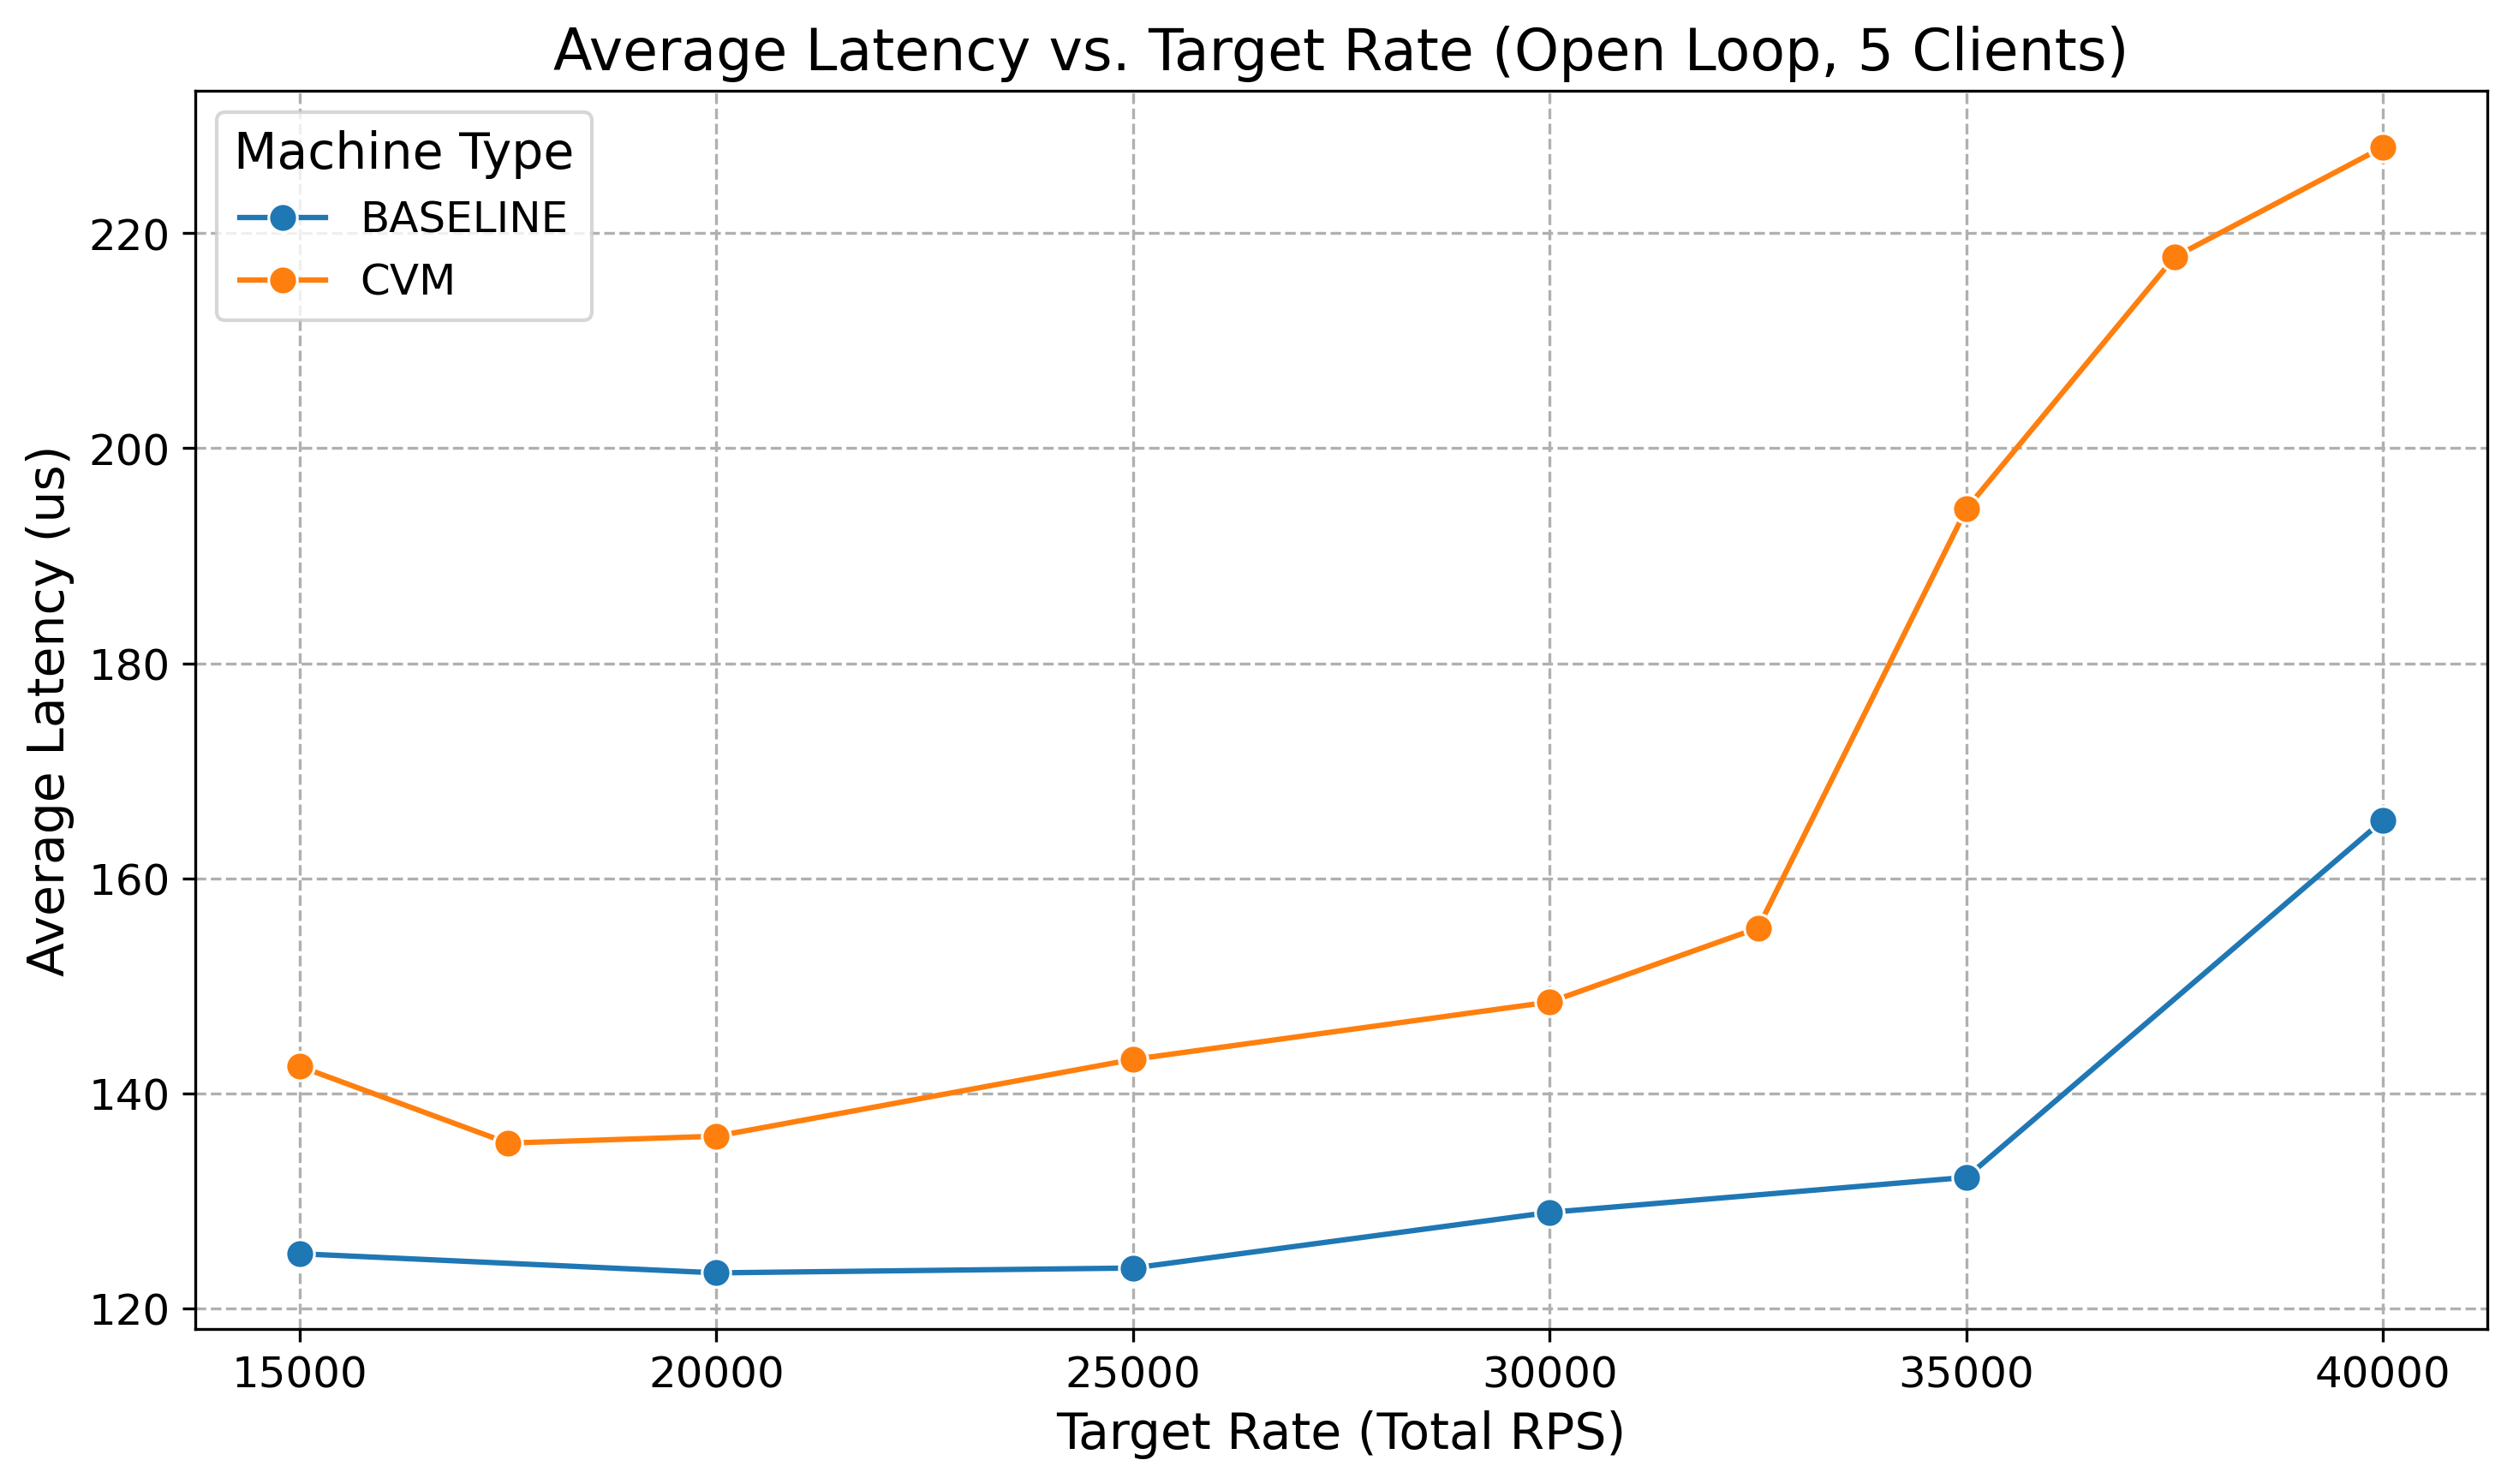

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=open_loop_plot, x='target_rate_total_hz', y='latency_avg_us', hue='log_type', marker='o', linewidth=1.5, markersize=8)

plt.title('Average Latency vs. Target Rate (Open Loop, 5 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Average Latency (us)')
plt.grid(True, linestyle='--')

# Get the current legend object and update labels
legend = plt.gca().get_legend()
new_labels = [l.get_text().upper() for l in legend.get_texts()]
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)
legend.set_title('Machine Type')

plt.tight_layout()
plt.show()

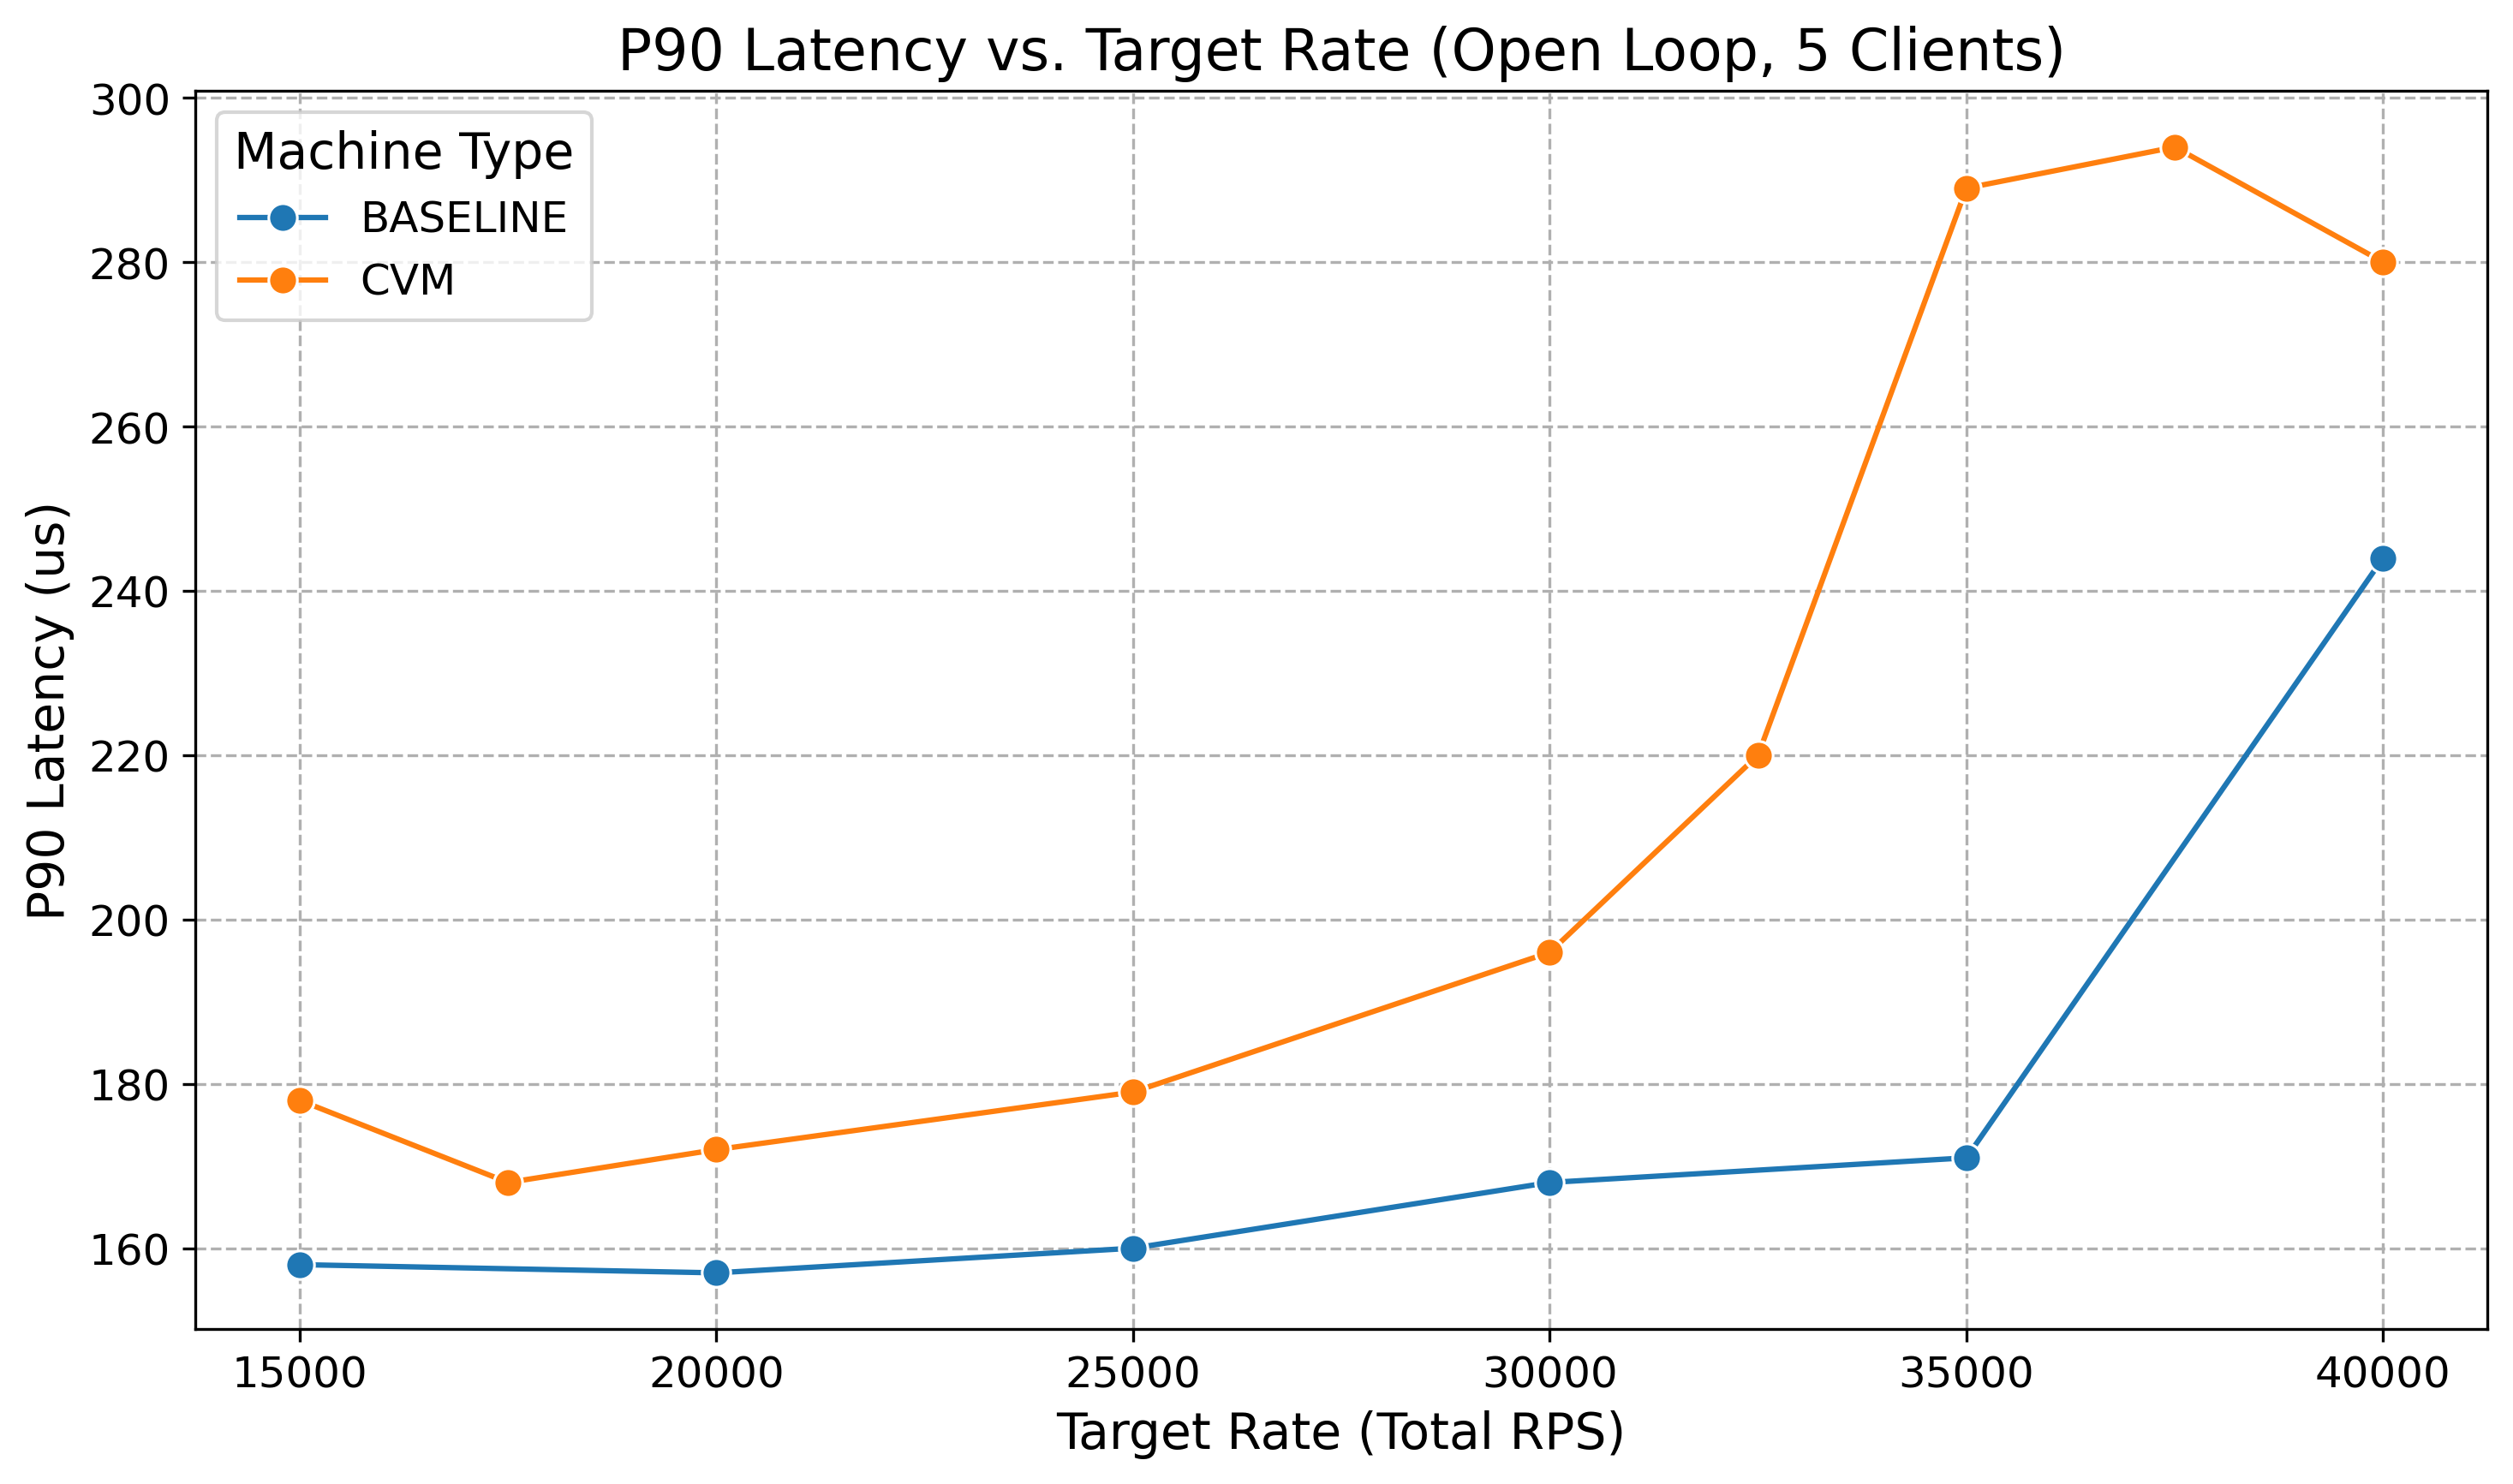

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=open_loop_plot, x='target_rate_total_hz', y='latency_p90_us', hue='log_type', marker='o', linewidth=1.5, markersize=8)

plt.title('P90 Latency vs. Target Rate (Open Loop, 5 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('P90 Latency (us)')
plt.grid(True, linestyle='--')

# Get the current legend object and update labels
legend = plt.gca().get_legend()
new_labels = [l.get_text().upper() for l in legend.get_texts()]
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)
legend.set_title('Machine Type')

plt.tight_layout()
plt.show()

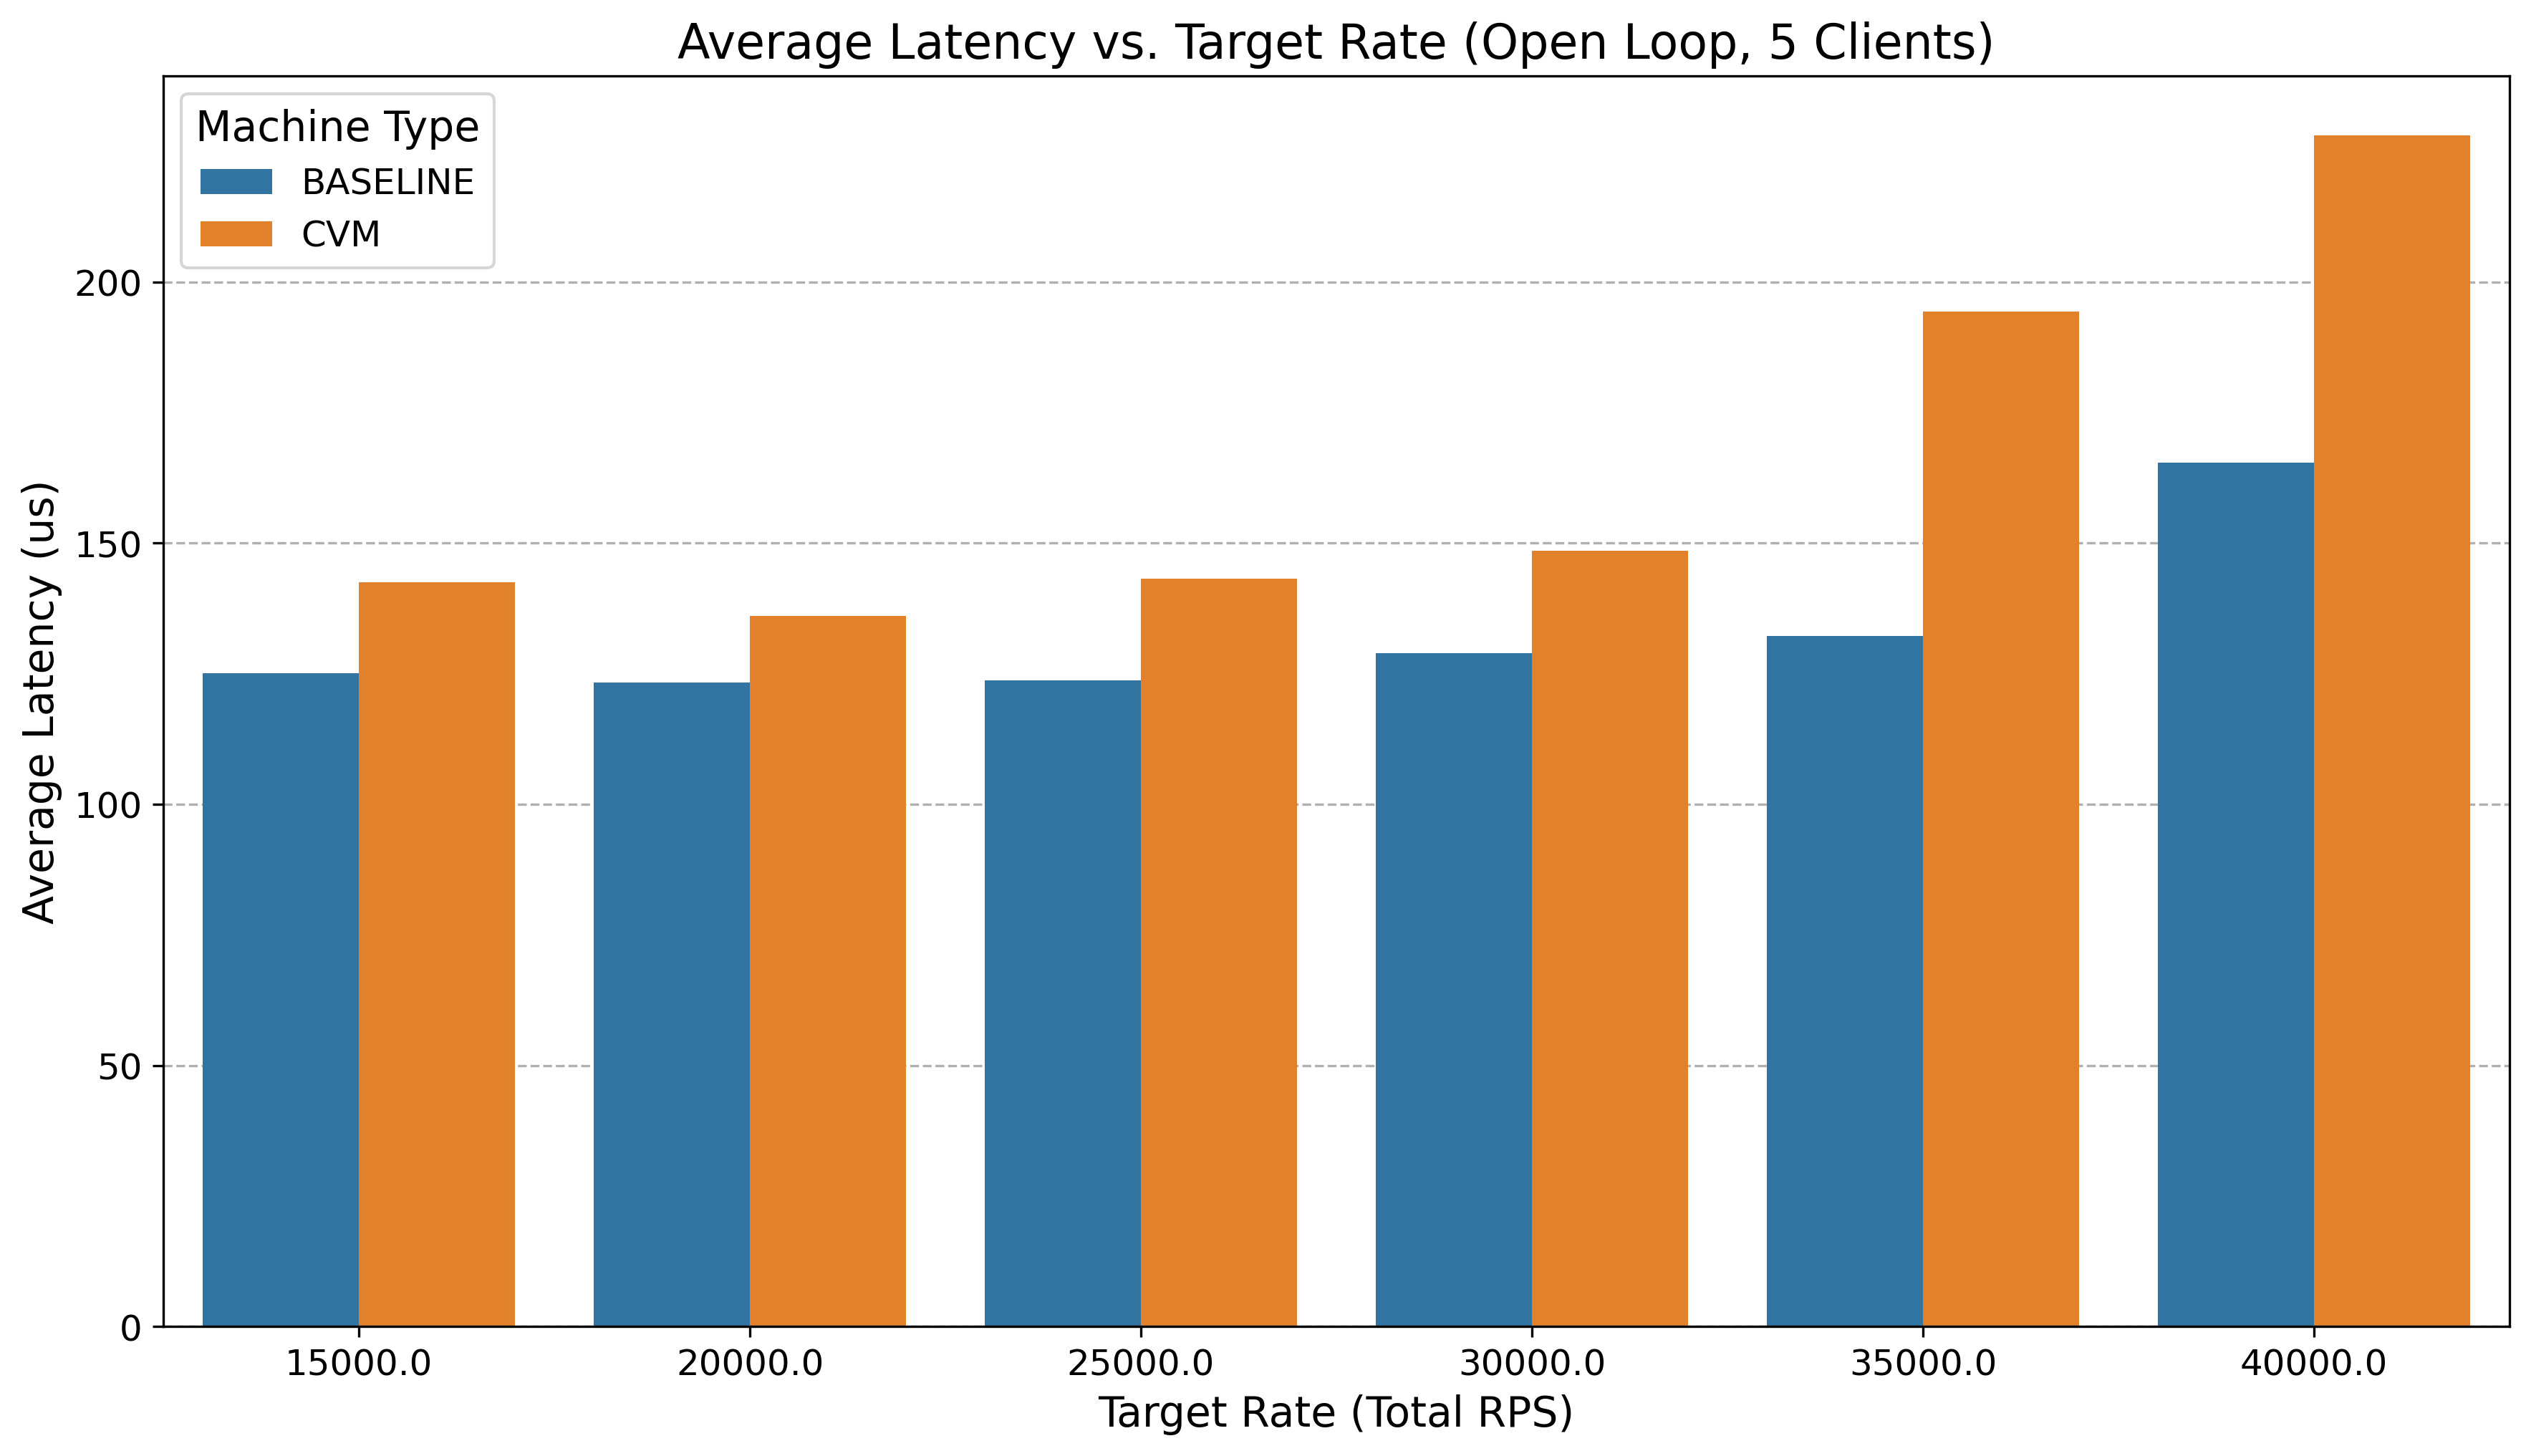

In [19]:
# Calculate the number of unique log types for each target rate
rate_counts = open_loop_plot.groupby('target_rate_total_hz')['log_type'].nunique()

# Identify target rates that have both 'baseline' and 'cvm' (assuming these are the only two expected)
valid_rates = rate_counts[rate_counts == 2].index

# Filter the dataframe to include only these valid rates
filtered_open_loop_plot = open_loop_plot[open_loop_plot['target_rate_total_hz'].isin(valid_rates)]

plt.figure(figsize=(12, 7)) # Adjusted figure size for better bar visibility
# Use the filtered dataframe for plotting
sns.barplot(data=filtered_open_loop_plot, x='target_rate_total_hz', y='latency_avg_us', hue='log_type')

plt.title('Average Latency vs. Target Rate (Open Loop, 5 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Average Latency (us)')
plt.grid(True, axis='y', linestyle='--') # Keep grid on y-axis

# Get the current legend object and update labels
legend = plt.gca().get_legend()
# Check if legend exists before trying to modify it
if legend:
    new_labels = [l.get_text().upper() for l in legend.get_texts()]
    for t, l in zip(legend.get_texts(), new_labels):
        t.set_text(l)
    legend.set_title('Machine Type')

plt.tight_layout()
plt.show()

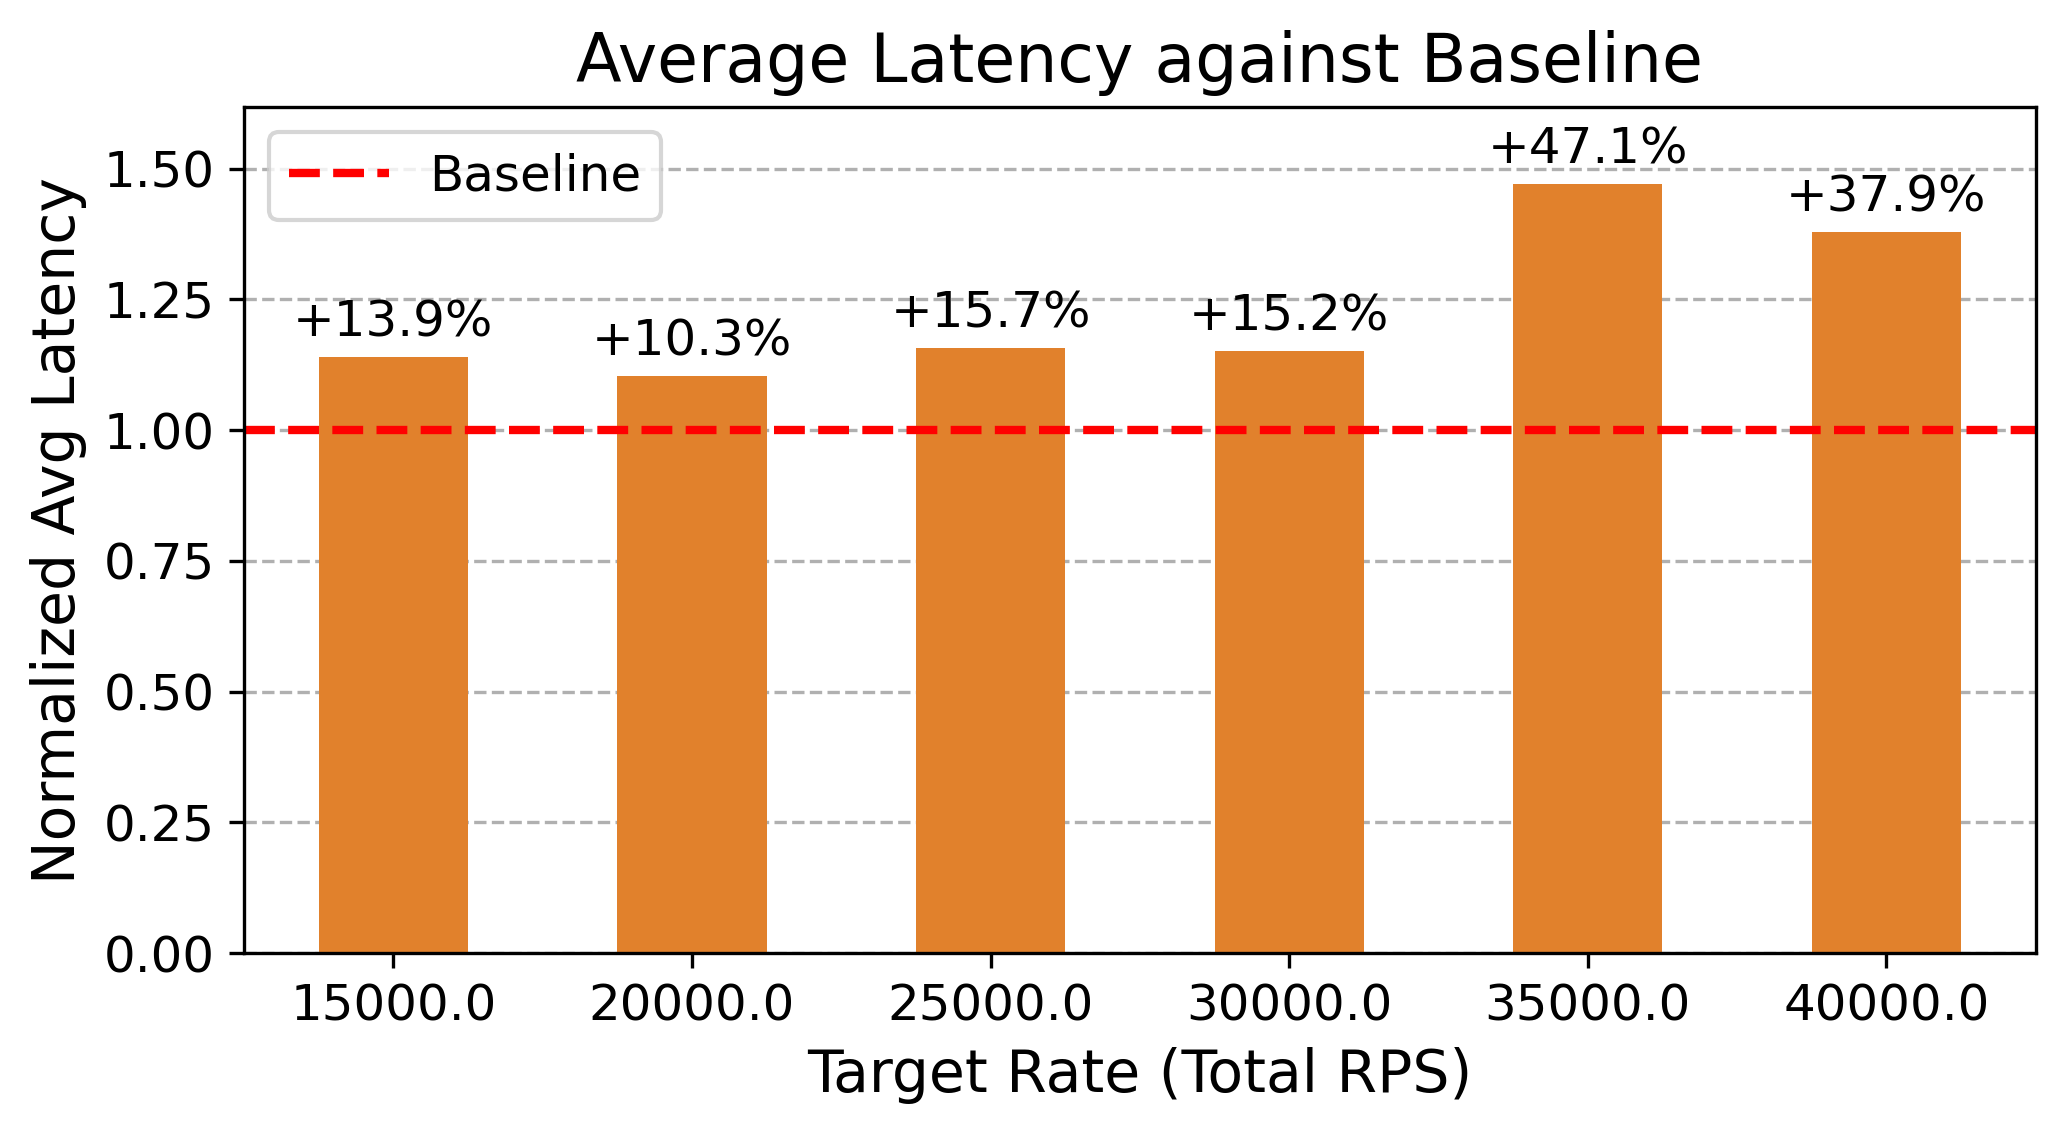

log_type  target_rate_total_hz  normalized_latency
0                      15000.0            1.139394
1                      20000.0            1.103137
2                      25000.0            1.156871
3                      30000.0            1.151801
4                      35000.0            1.470659
5                      40000.0            1.378663


In [20]:
# Pivot the table to get baseline and cvm latencies side-by-side for each target rate
pivot_open_loop = filtered_open_loop_plot.pivot(index='target_rate_total_hz', columns='log_type', values='latency_avg_us')

# Calculate the normalized latency (CVM / Baseline)
# Ensure 'baseline' and 'cvm' columns exist after pivoting
if 'baseline' in pivot_open_loop.columns and 'cvm' in pivot_open_loop.columns:
    pivot_open_loop['normalized_latency'] = pivot_open_loop['cvm'] / pivot_open_loop['baseline']
else:
    print("Error: 'baseline' or 'cvm' log_type not found for all target rates.")
    pivot_open_loop['normalized_latency'] = np.nan # Add column with NaNs if types missing

# Reset index to make 'target_rate_total_hz' a column again for plotting
pivot_open_loop = pivot_open_loop.reset_index()

# Plotting the normalized latency
plt.figure(figsize=(7, 4))
barplot = sns.barplot(data=pivot_open_loop, x='target_rate_total_hz', y='normalized_latency', color=sns.color_palette()[1], width=0.5) # Use a single color

# Add text annotations for latency increase percentage
for index, row in pivot_open_loop.iterrows():
    target_rate = row['target_rate_total_hz']
    normalized_latency = row['normalized_latency']
    # Calculate latency increase percentage
    increase_pct = (normalized_latency - 1) * 100
    # Position the text slightly above the bar
    bar_x_center = barplot.patches[index].get_x() + barplot.patches[index].get_width() / 2
    plt.text(x=bar_x_center,
             y=normalized_latency + 0.02, # Adjust vertical offset as needed
             s=f'{increase_pct:+.1f}%', # Format increase percentage
             ha='center', # Horizontal alignment
             va='bottom', # Vertical alignment
             fontsize=12,
             color='black')

plt.title('Average Latency against Baseline')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Normalized Avg Latency')
plt.grid(True, axis='y', linestyle='--')
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()

# Adjust y-axis limits to give more space for annotations
plt.ylim(bottom=0, top=max(pivot_open_loop['normalized_latency'].max() * 1.1, 1.2)) # Adjust top limit based on data

plt.tight_layout()
plt.show()

print(pivot_open_loop[['target_rate_total_hz', 'normalized_latency']])

In [21]:
open_loop_20c = open_loop_logs[(open_loop_logs['clients'] == 20) &(open_loop_logs["log_type"] != "misc") & (open_loop_logs['target_rate_total_hz'] < 70000)]
open_loop_20c

,log_type,filename,mode,clients,target_rate_client_hz,target_rate_total_hz,total_requests,duration_sec,throughput_rps,latency_avg_us,latency_p50_us,latency_p90_us,latency_p95_us,latency_p99_us
6,baseline,open_20c_500p.log,open,20,500.0,10000.0,101068,10,10106.8,146.574,151,186,200,235
7,baseline,open_20c_1500p.log,open,20,1500.0,30000.0,303482,10,30348.2,175.026,169,233,252,298
8,baseline,open_20c_2000p.log,open,20,2000.0,40000.0,404236,10,40423.6,210.799,200,290,320,420
17,baseline,open_20c_1000p.log,open,20,1000.0,20000.0,202124,10,20212.4,157.392,157,199,221,248
21,baseline,open_20c_2250p.log,open,20,2250.0,45000.0,455175,10,45517.5,284.887,247,469,516,627
23,baseline,open_20c_2750p.log,open,20,2750.0,55000.0,548449,10,54844.9,308.564,282,430,594,921
27,baseline,open_20c_3000p.log,open,20,3000.0,60000.0,598383,10,59838.3,400.598,374,616,694,781
33,baseline,open_20c_2500p.log,open,20,2500.0,50000.0,494809,10,49480.9,333.120,267,631,765,933
41,cvm,open_20c_500p.log,open,20,500.0,10000.0,101067,10,10106.7,163.714,160,202,228,287
42,cvm,open_20c_1500p.log,open,20,1500.0,30000.0,303486,10,30348.6,192.638,187,256,283,319


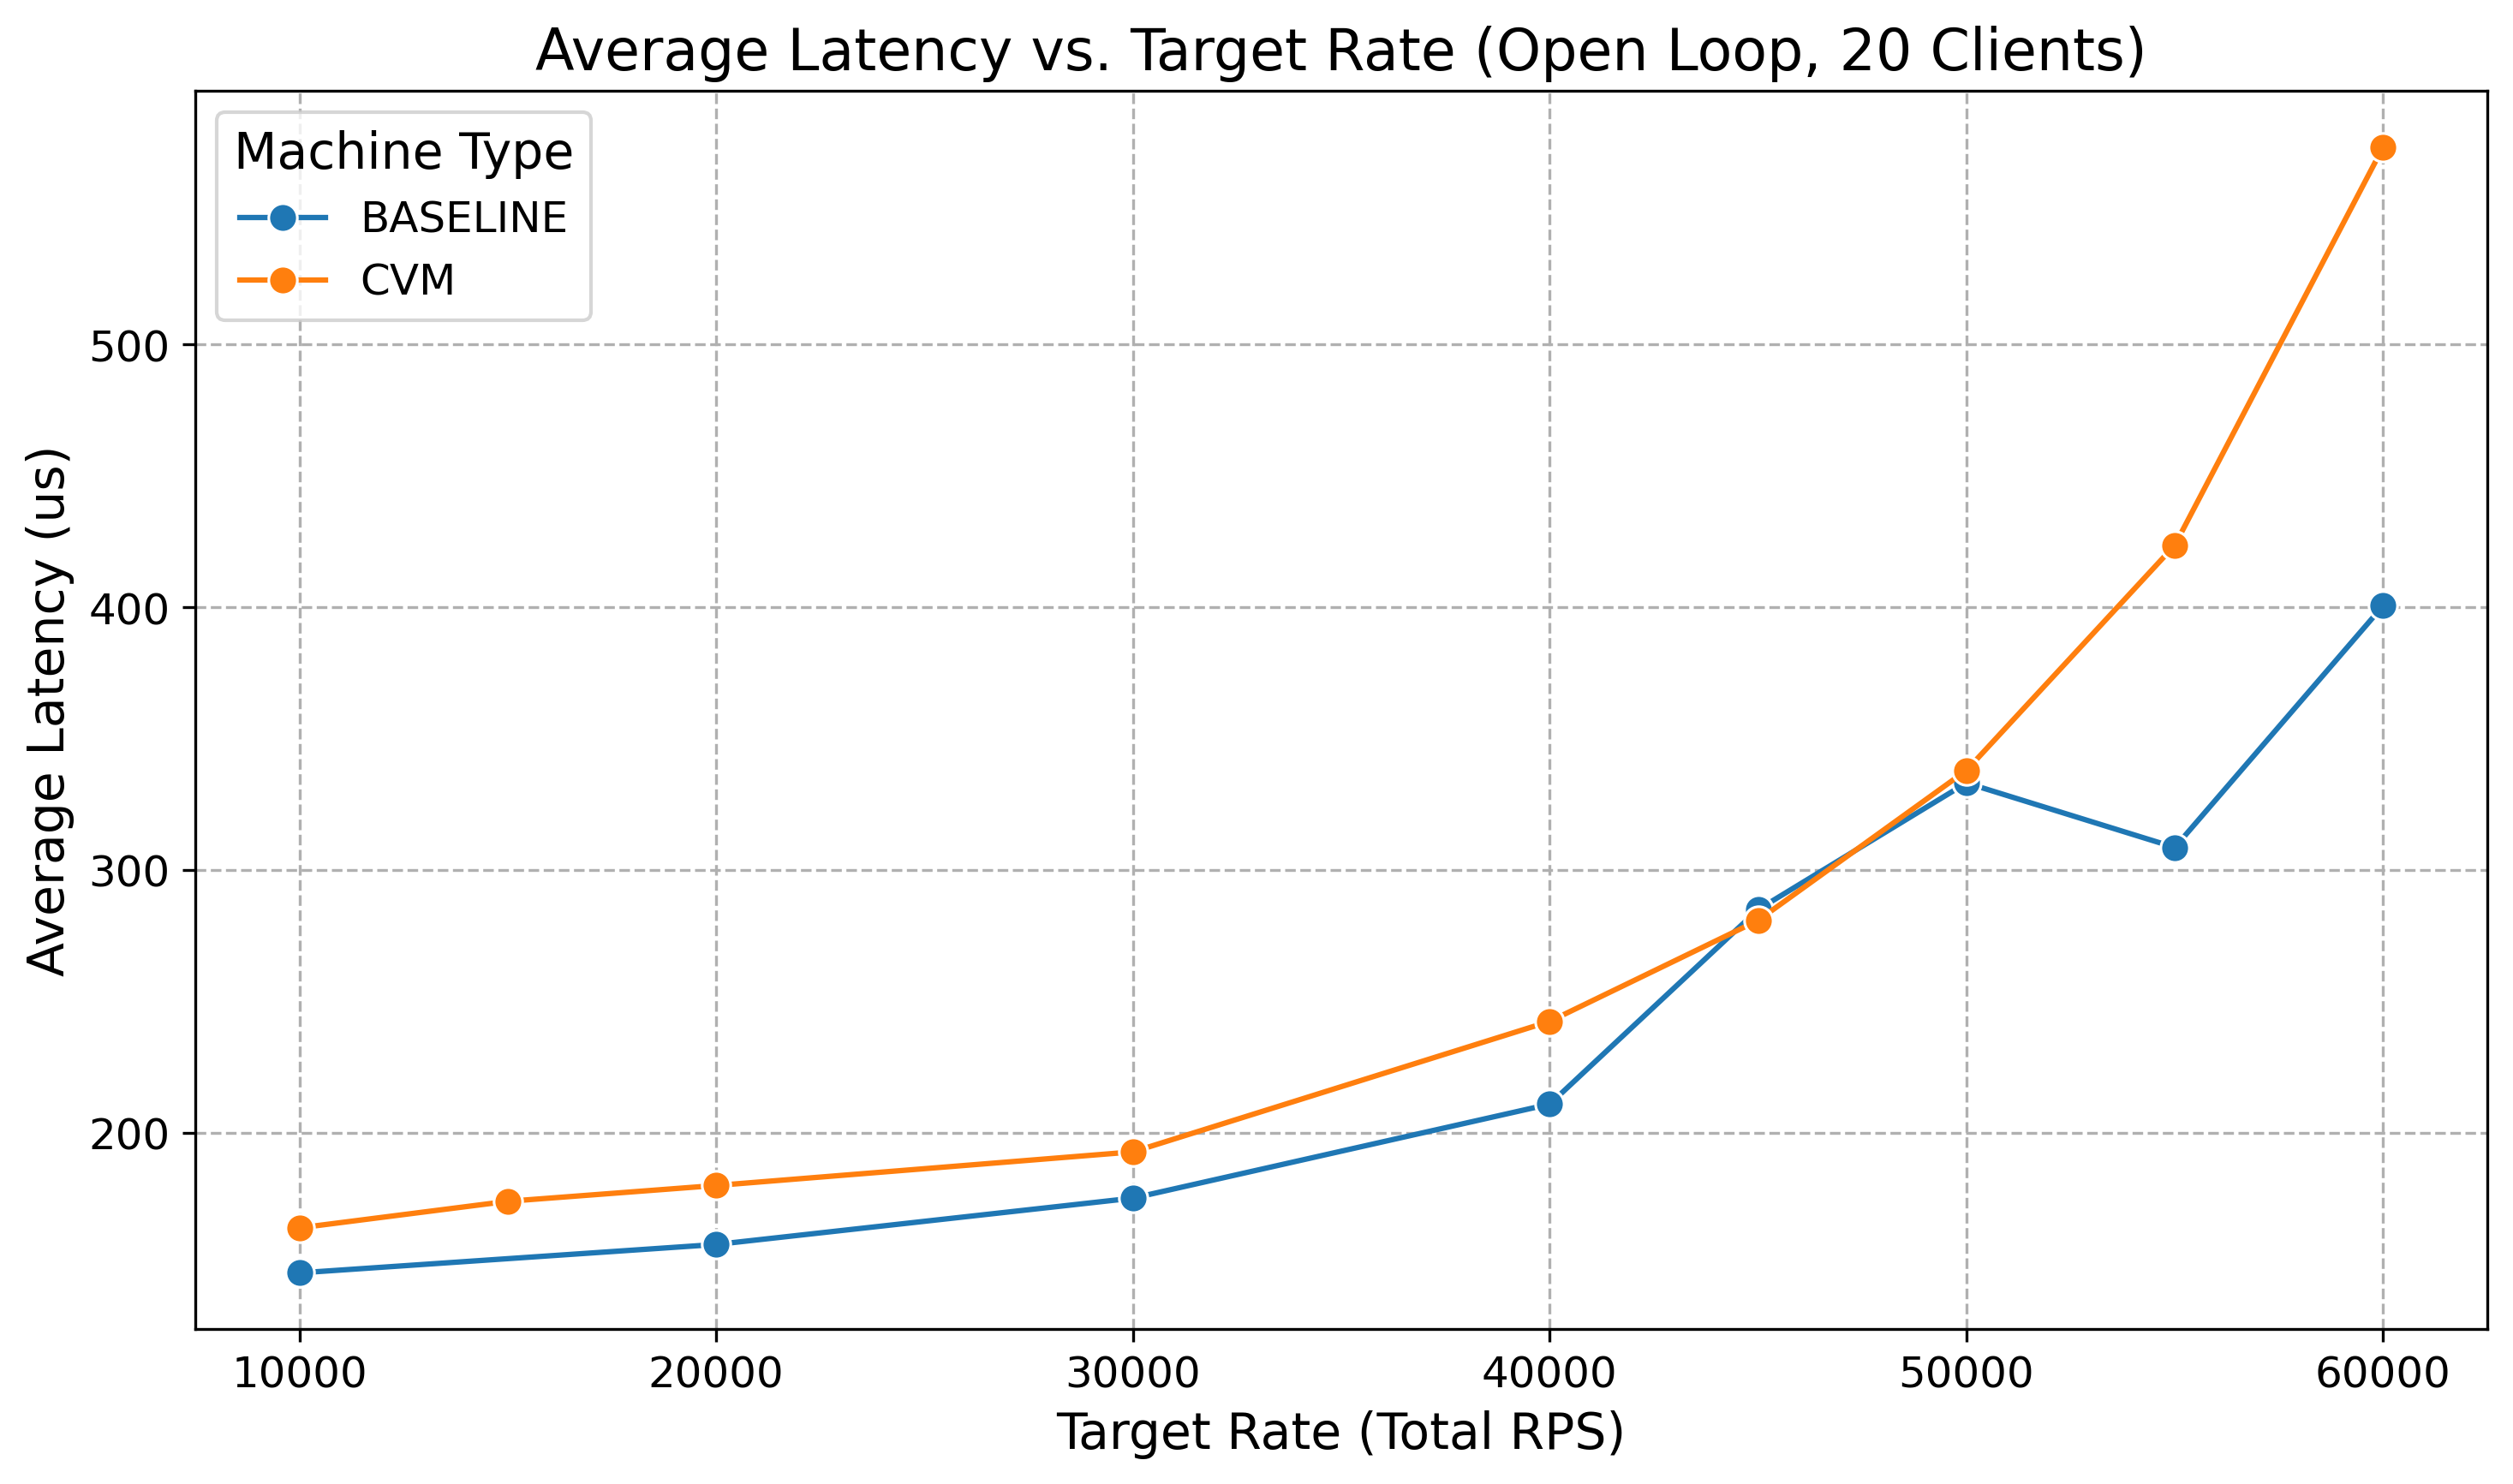

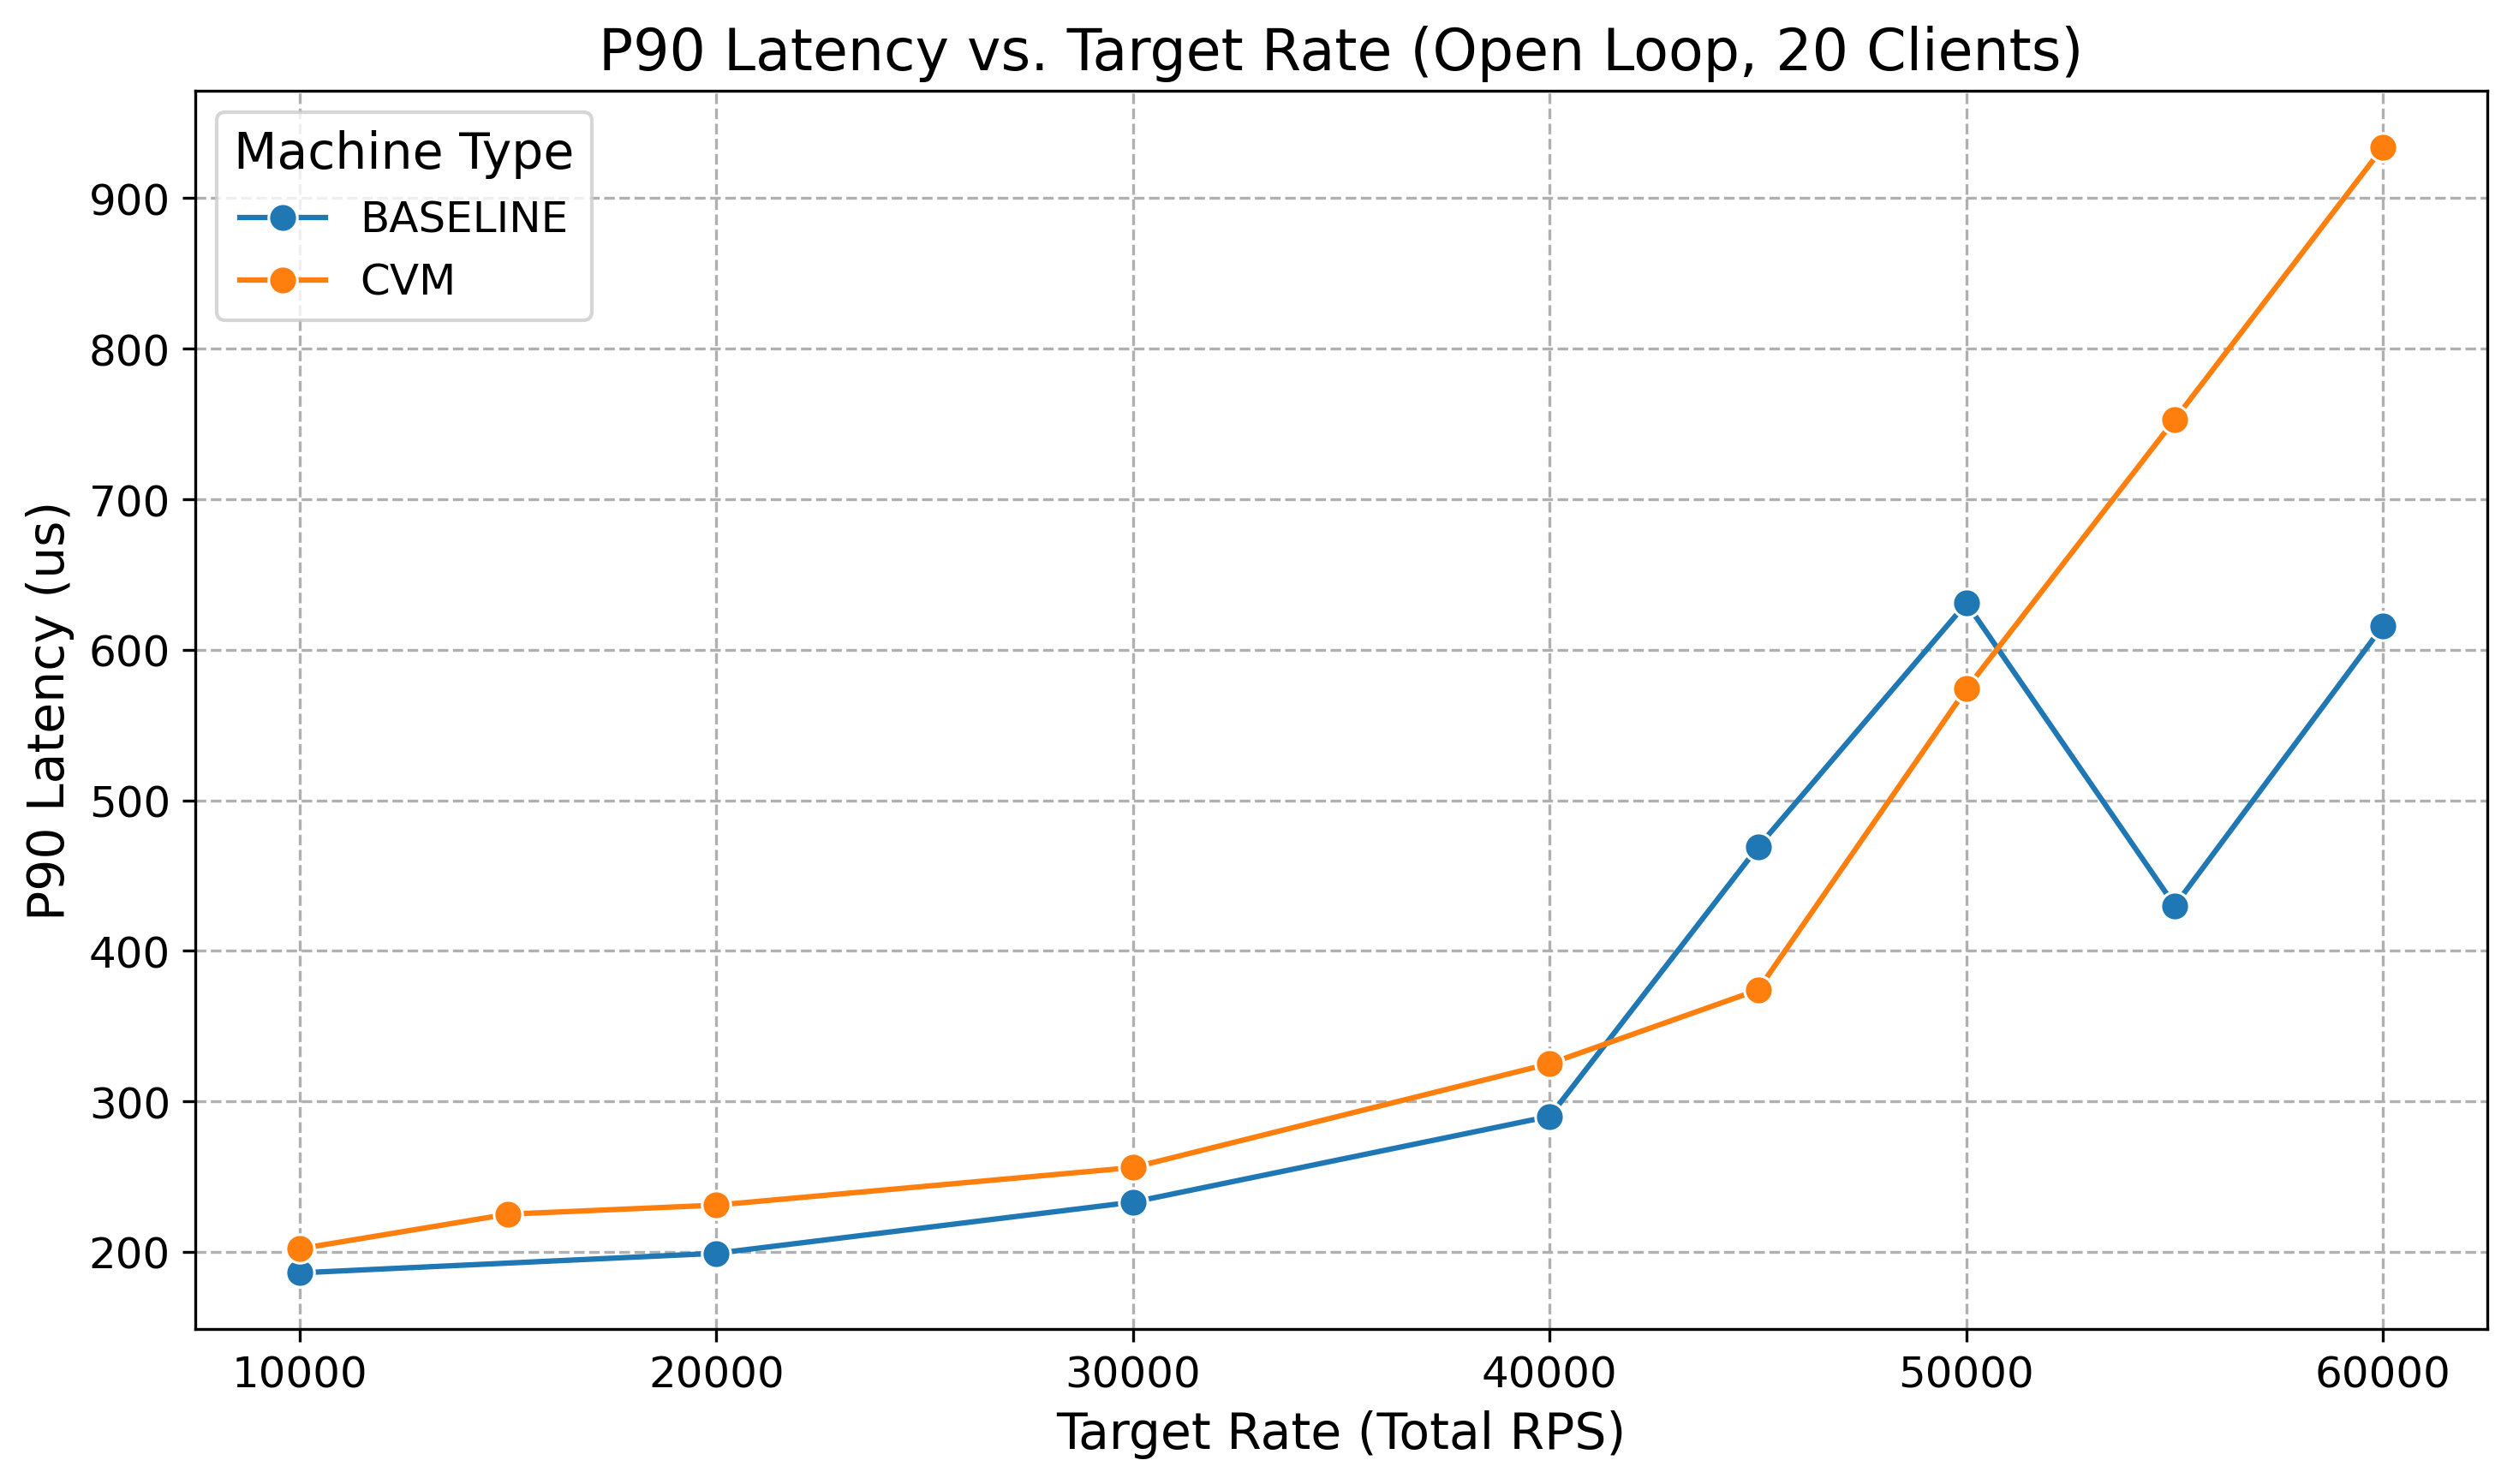

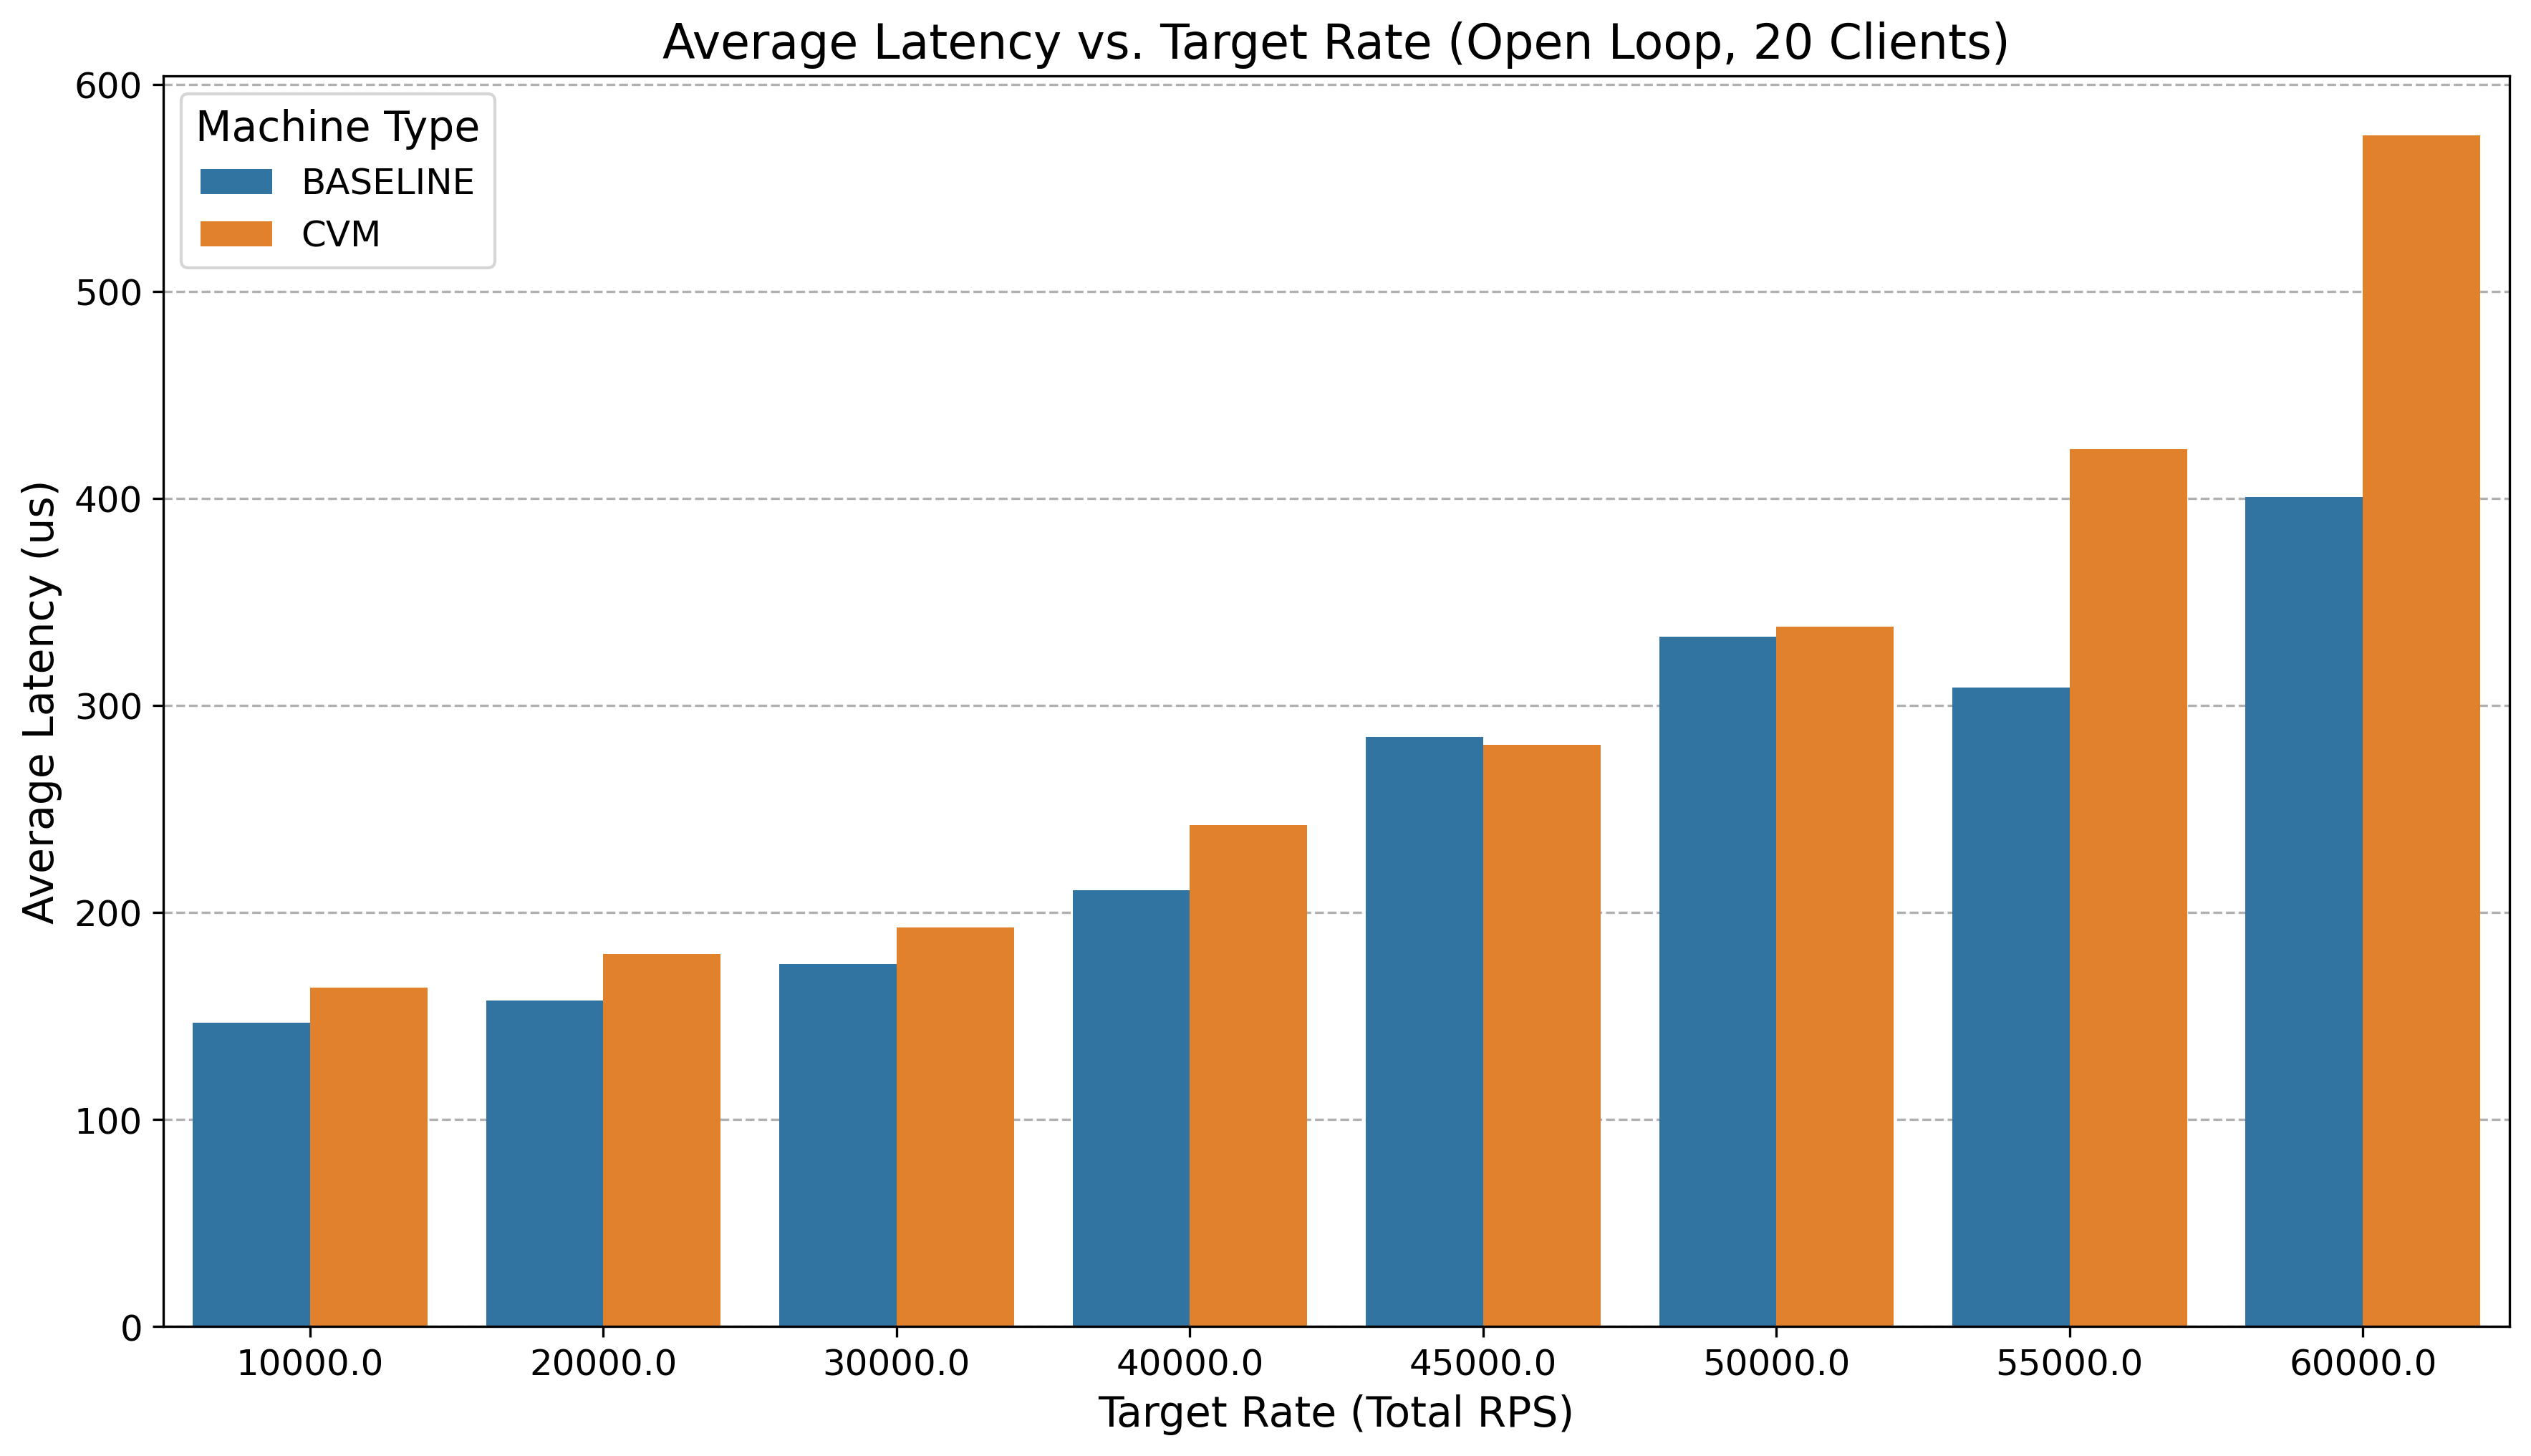

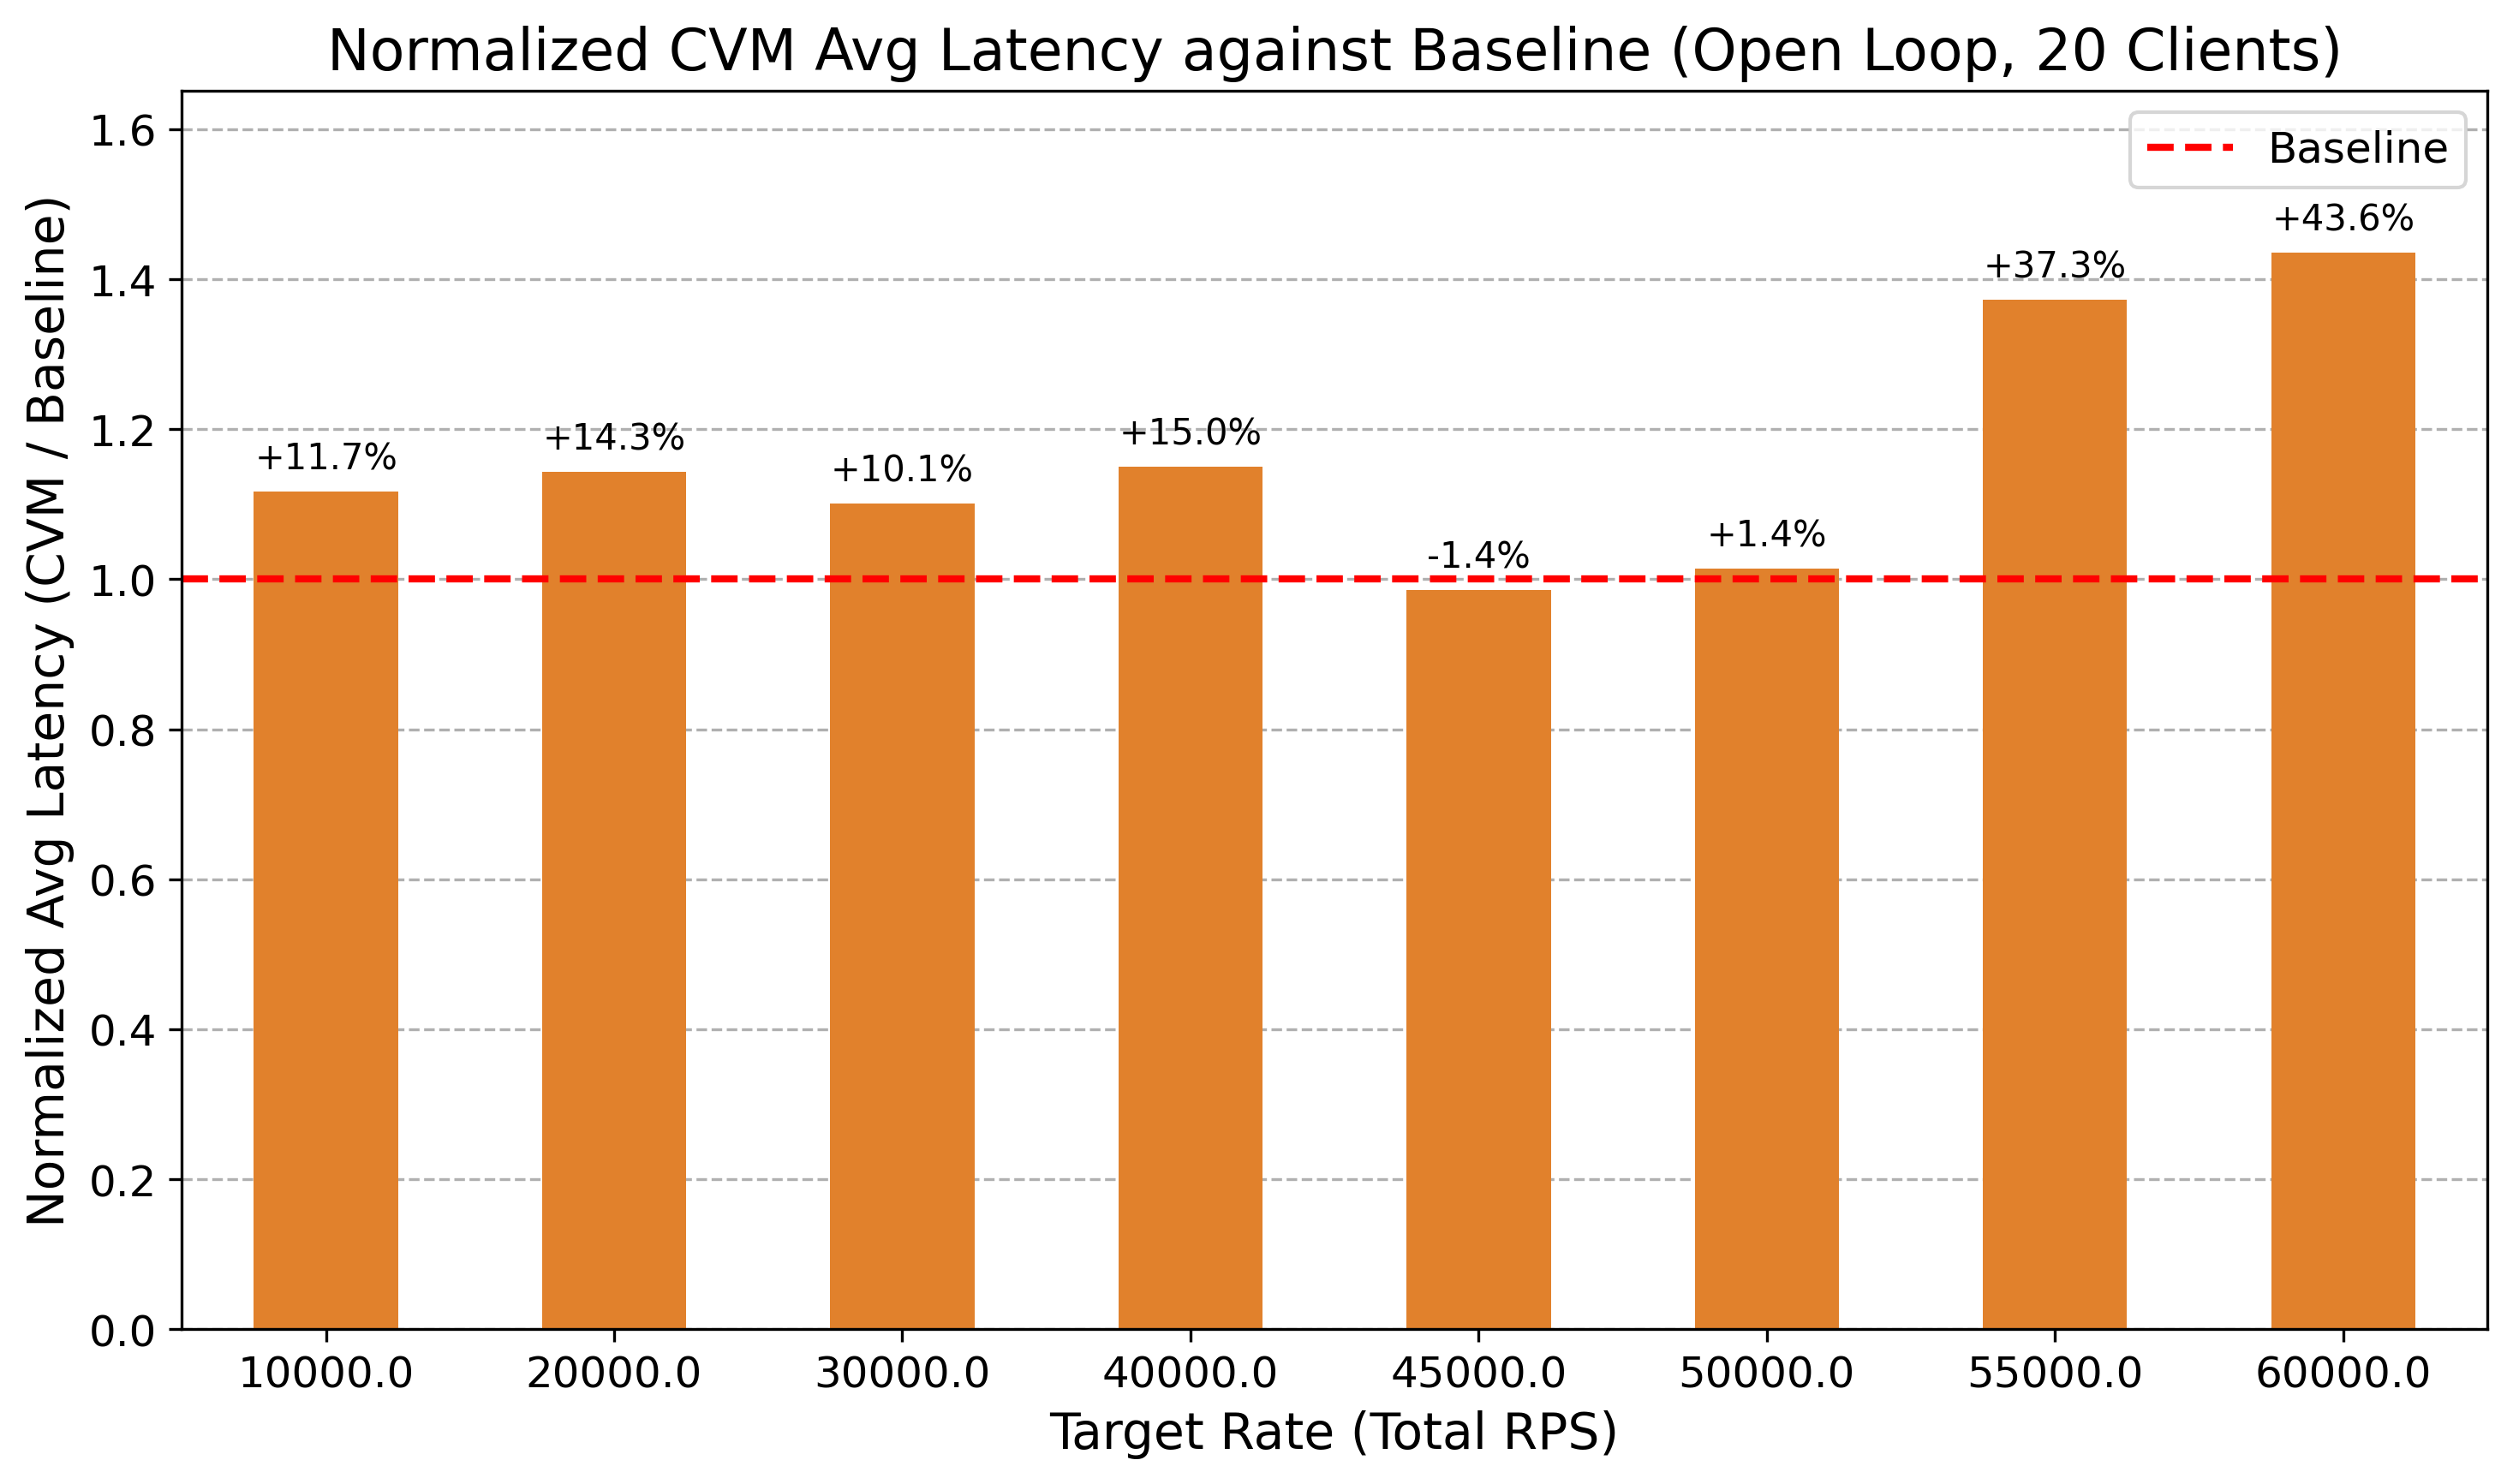

Normalized Average Latency (20 Clients):
log_type  target_rate_total_hz  normalized_latency
0                      10000.0            1.116938
1                      20000.0            1.142688
2                      30000.0            1.100625
3                      40000.0            1.149569
4                      45000.0            0.985531
5                      50000.0            1.014337
6                      55000.0            1.372879
7                      60000.0            1.435938


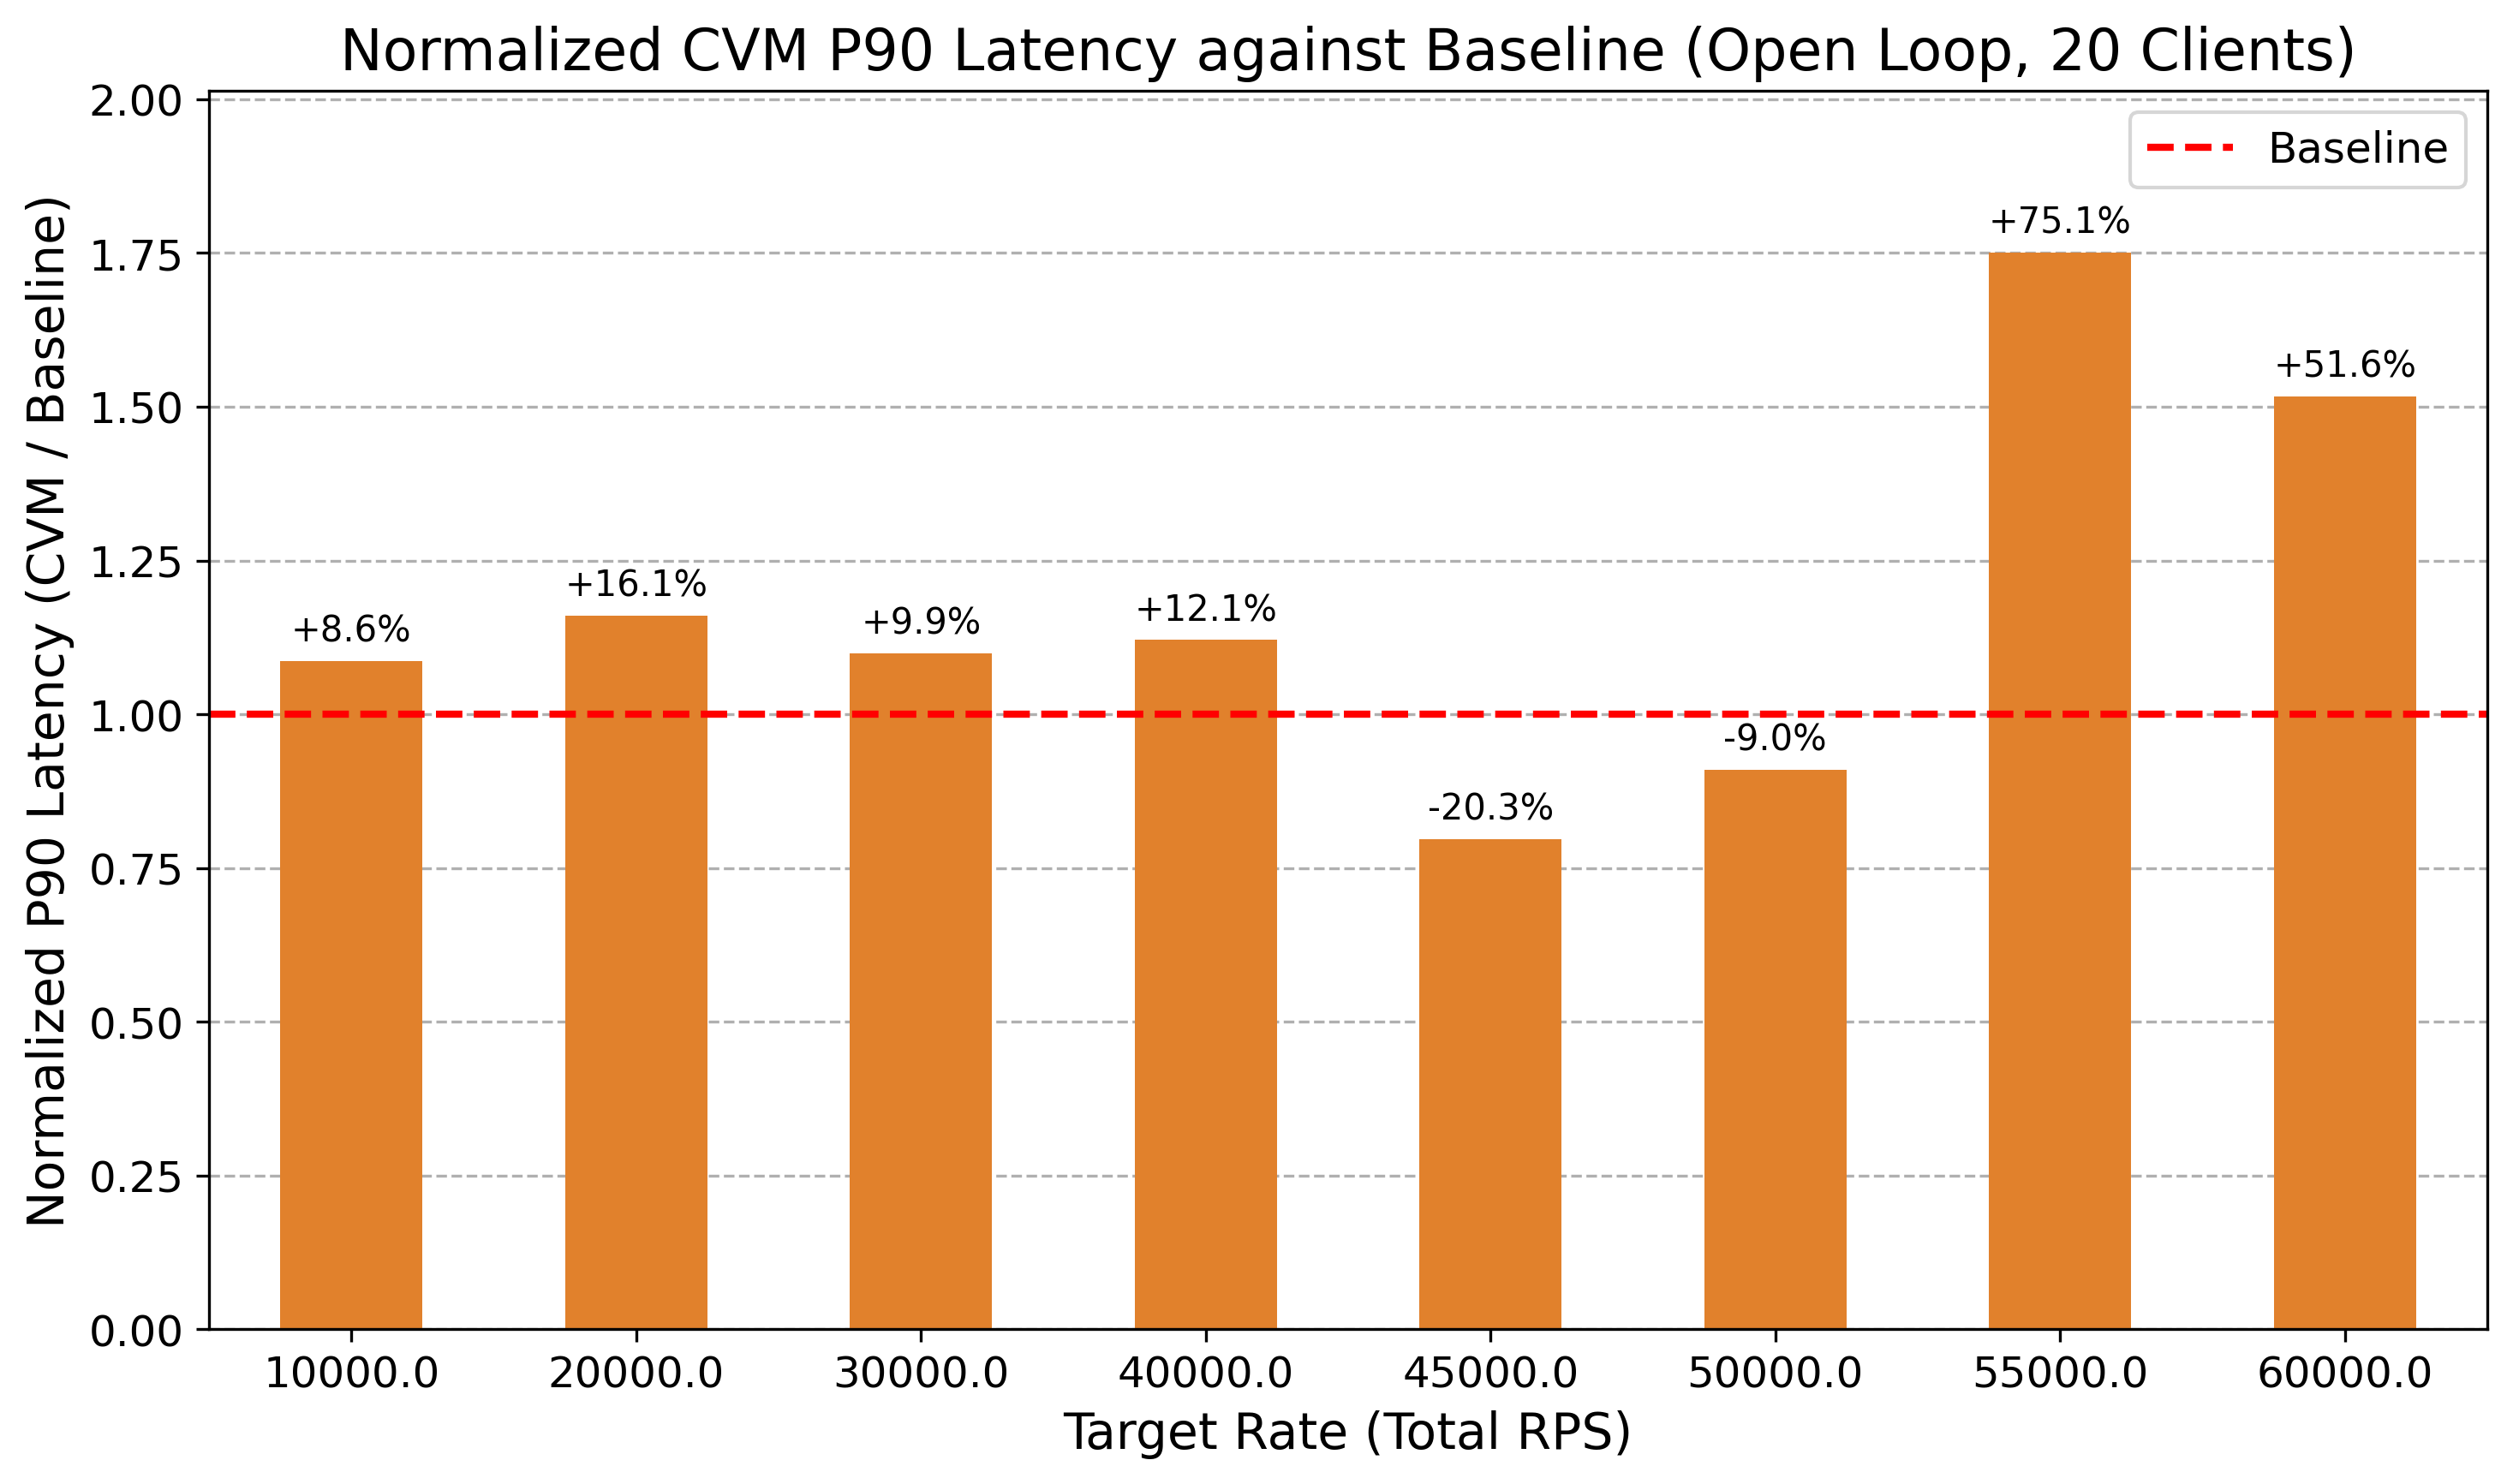


Normalized P90 Latency (20 Clients):
log_type  target_rate_total_hz  normalized_latency
0                      10000.0            1.086022
1                      20000.0            1.160804
2                      30000.0            1.098712
3                      40000.0            1.120690
4                      45000.0            0.797441
5                      50000.0            0.909667
6                      55000.0            1.751163
7                      60000.0            1.516234


In [22]:
# Sort the dataframe for line plots
open_loop_20c_sorted = open_loop_20c.sort_values(by='target_rate_total_hz')

# Plot 1a: Average Latency vs. Target Rate (Line Plot)
plt.figure(figsize=(10, 6))
sns.lineplot(data=open_loop_20c_sorted, x='target_rate_total_hz', y='latency_avg_us', hue='log_type', marker='o', linewidth=1.5, markersize=8)
plt.title('Average Latency vs. Target Rate (Open Loop, 20 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Average Latency (us)')
plt.grid(True, linestyle='--')
legend = plt.gca().get_legend()
new_labels = [l.get_text().upper() for l in legend.get_texts()]
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)
legend.set_title('Machine Type')
plt.tight_layout()
plt.show()

# Plot 1b: P90 Latency vs. Target Rate (Line Plot)
plt.figure(figsize=(10, 6))
sns.lineplot(data=open_loop_20c_sorted, x='target_rate_total_hz', y='latency_p90_us', hue='log_type', marker='o', linewidth=1.5, markersize=8)
plt.title('P90 Latency vs. Target Rate (Open Loop, 20 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('P90 Latency (us)')
plt.grid(True, linestyle='--')
legend = plt.gca().get_legend()
new_labels = [l.get_text().upper() for l in legend.get_texts()]
for t, l in zip(legend.get_texts(), new_labels):
    t.set_text(l)
legend.set_title('Machine Type')
plt.tight_layout()
plt.show()

# --- Filter data for bar plots and normalization ---
# Calculate the number of unique log types for each target rate
rate_counts_20c = open_loop_20c.groupby('target_rate_total_hz')['log_type'].nunique()
# Identify target rates that have both 'baseline' and 'cvm'
valid_rates_20c = rate_counts_20c[rate_counts_20c == 2].index
# Filter the dataframe
filtered_open_loop_20c = open_loop_20c[open_loop_20c['target_rate_total_hz'].isin(valid_rates_20c)]


# Plot 2: Average Latency per Target Rate (Bar Plot)
plt.figure(figsize=(12, 7))
sns.barplot(data=filtered_open_loop_20c, x='target_rate_total_hz', y='latency_avg_us', hue='log_type')
plt.title('Average Latency vs. Target Rate (Open Loop, 20 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Average Latency (us)')
plt.grid(True, axis='y', linestyle='--')
legend = plt.gca().get_legend()
if legend:
    new_labels = [l.get_text().upper() for l in legend.get_texts()]
    for t, l in zip(legend.get_texts(), new_labels):
        t.set_text(l)
    legend.set_title('Machine Type')
plt.tight_layout()
plt.show()


# Plot 3: Normalized Average Latency (Bar Plot)
# Pivot the table
pivot_open_loop_20c_avg = filtered_open_loop_20c.pivot(index='target_rate_total_hz', columns='log_type', values='latency_avg_us')
# Calculate normalized latency
if 'baseline' in pivot_open_loop_20c_avg.columns and 'cvm' in pivot_open_loop_20c_avg.columns:
    pivot_open_loop_20c_avg['normalized_latency'] = pivot_open_loop_20c_avg['cvm'] / pivot_open_loop_20c_avg['baseline']
else:
    print("Error: 'baseline' or 'cvm' log_type not found for all target rates (Avg Latency).")
    pivot_open_loop_20c_avg['normalized_latency'] = np.nan
pivot_open_loop_20c_avg = pivot_open_loop_20c_avg.reset_index()

# Plotting
plt.figure(figsize=(10, 6))
barplot_avg_20c = sns.barplot(data=pivot_open_loop_20c_avg, x='target_rate_total_hz', y='normalized_latency', color=sns.color_palette()[1], width=0.5)
# Add annotations
for index, row in pivot_open_loop_20c_avg.iterrows():
    normalized_latency = row['normalized_latency']
    increase_pct = (normalized_latency - 1) * 100
    bar_x_center = barplot_avg_20c.patches[index].get_x() + barplot_avg_20c.patches[index].get_width() / 2
    plt.text(x=bar_x_center, y=normalized_latency + 0.02, s=f'{increase_pct:+.1f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title('Normalized CVM Avg Latency against Baseline (Open Loop, 20 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Normalized Avg Latency (CVM / Baseline)')
plt.grid(True, axis='y', linestyle='--')
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()
plt.ylim(bottom=0, top=max(pivot_open_loop_20c_avg['normalized_latency'].max() * 1.15, 1.2))
plt.tight_layout()
plt.show()
print("Normalized Average Latency (20 Clients):")
print(pivot_open_loop_20c_avg[['target_rate_total_hz', 'normalized_latency']])


# Plot 4: Normalized P90 Latency (Bar Plot) - Similar to Plot 3 but for P90
# Pivot the table for P90
pivot_open_loop_20c_p90 = filtered_open_loop_20c.pivot(index='target_rate_total_hz', columns='log_type', values='latency_p90_us')
# Calculate normalized latency
if 'baseline' in pivot_open_loop_20c_p90.columns and 'cvm' in pivot_open_loop_20c_p90.columns:
    pivot_open_loop_20c_p90['normalized_latency'] = pivot_open_loop_20c_p90['cvm'] / pivot_open_loop_20c_p90['baseline']
else:
    print("Error: 'baseline' or 'cvm' log_type not found for all target rates (P90 Latency).")
    pivot_open_loop_20c_p90['normalized_latency'] = np.nan
pivot_open_loop_20c_p90 = pivot_open_loop_20c_p90.reset_index()

# Plotting P90
plt.figure(figsize=(10, 6))
barplot_p90_20c = sns.barplot(data=pivot_open_loop_20c_p90, x='target_rate_total_hz', y='normalized_latency', color=sns.color_palette()[1], width=0.5)
# Add annotations
for index, row in pivot_open_loop_20c_p90.iterrows():
    normalized_latency = row['normalized_latency']
    increase_pct = (normalized_latency - 1) * 100
    bar_x_center = barplot_p90_20c.patches[index].get_x() + barplot_p90_20c.patches[index].get_width() / 2
    plt.text(x=bar_x_center, y=normalized_latency + 0.02, s=f'{increase_pct:+.1f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title('Normalized CVM P90 Latency against Baseline (Open Loop, 20 Clients)')
plt.xlabel('Target Rate (Total RPS)')
plt.ylabel('Normalized P90 Latency (CVM / Baseline)')
plt.grid(True, axis='y', linestyle='--')
plt.axhline(1, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.legend()
plt.ylim(bottom=0, top=max(pivot_open_loop_20c_p90['normalized_latency'].max() * 1.15, 1.2))
plt.tight_layout()
plt.show()
print("\nNormalized P90 Latency (20 Clients):")
print(pivot_open_loop_20c_p90[['target_rate_total_hz', 'normalized_latency']])

# Logging Cost

In [23]:
no_p_20c_2500p = 814020 / 1000000 # no print 20c 2500p
log_20c_2500p = 1436717 / 1000000 # log 20c 2500p

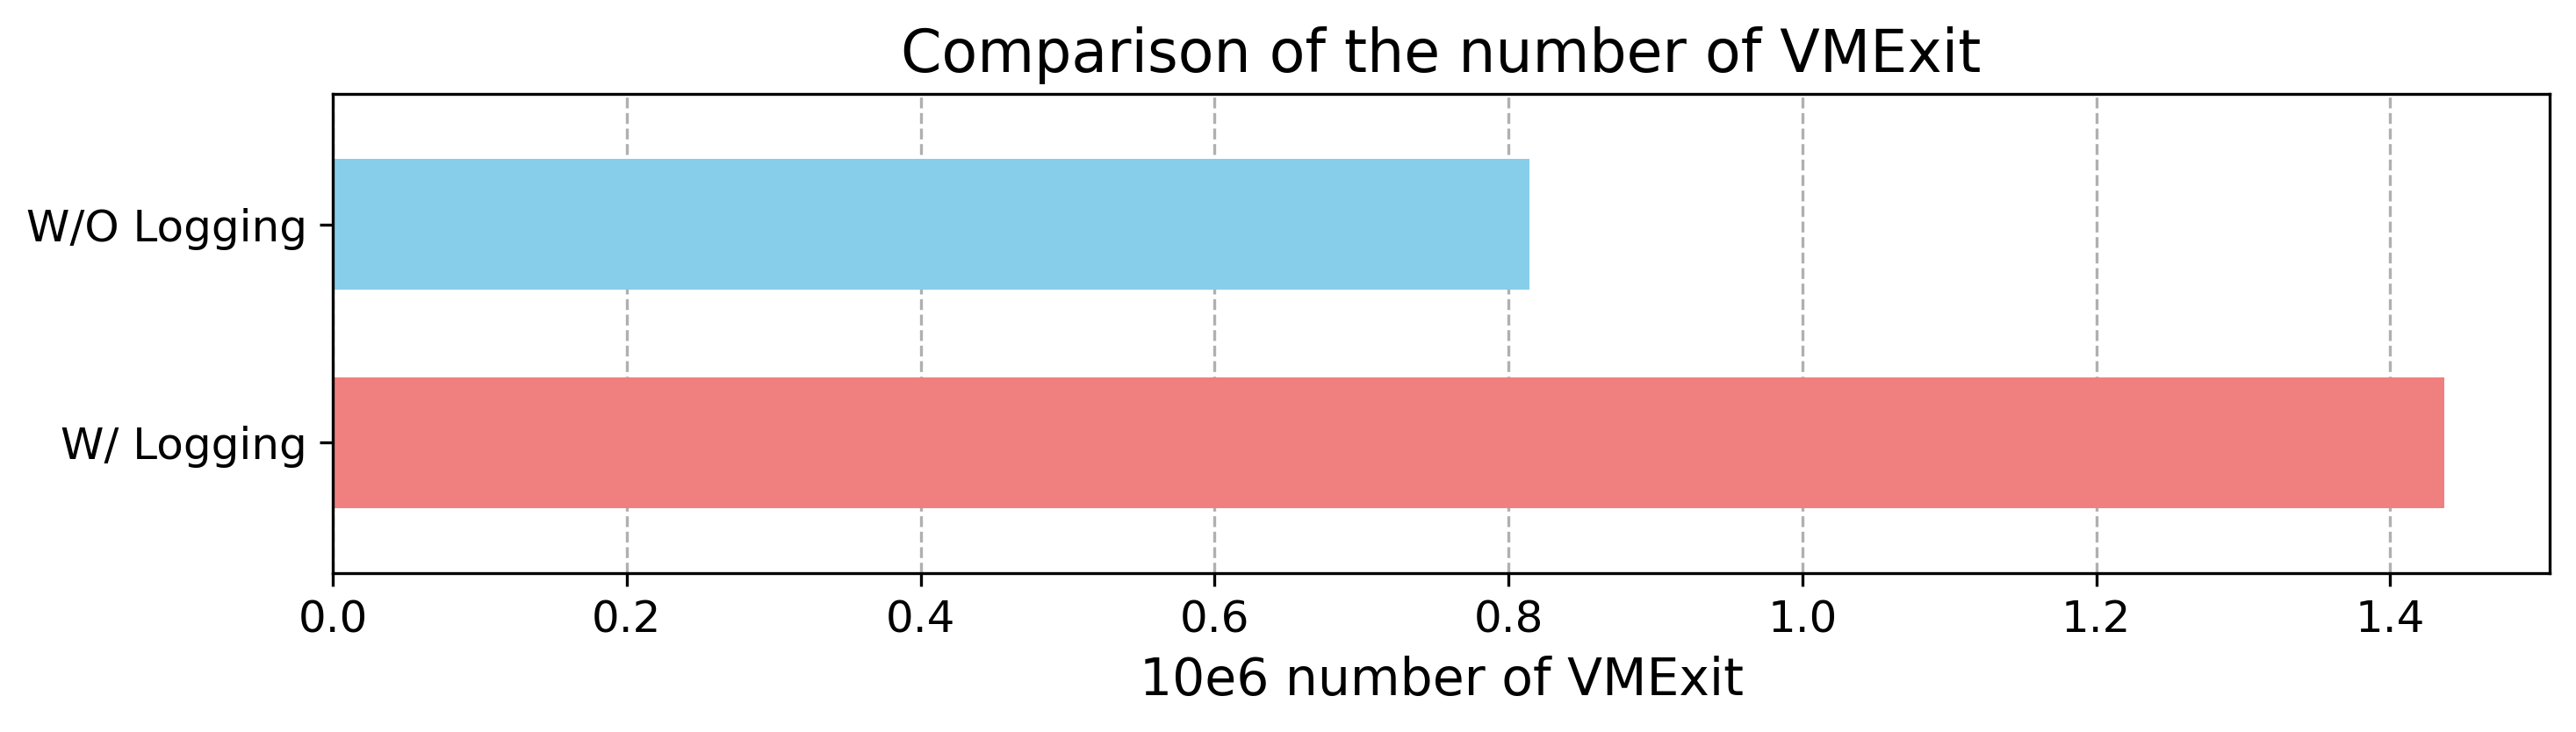

In [24]:
# Data for the plot
labels = ['W/O Logging', 'W/ Logging']
values = [no_p_20c_2500p, log_20c_2500p]

plt.figure(figsize=(10, 3)) # Adjust figure size as needed
# Set the height parameter to make bars narrower (default is 0.8)
bars = plt.barh(labels, values, color=['skyblue', 'lightcoral'], height=0.6)

plt.xlabel('10e6 number of VMExit')
plt.title('Comparison of the number of VMExit')
plt.gca().invert_yaxis() # Optional: display top bar first

# Add padding to the top and bottom
plt.ylim(len(labels) - 0.5 + 0.1, -0.5 - 0.1) # Adjust limits for padding (inverted axis)

plt.grid(True, axis='x', linestyle='--')

# Adjust x-axis limits to make space for labels
plt.xlim(right=max(values) * 1.05) # Add 5% padding to the right

plt.tight_layout()
plt.show()

In [25]:
hires_20c_2500p = 786377 / 1000000 # hires 20c 2500p

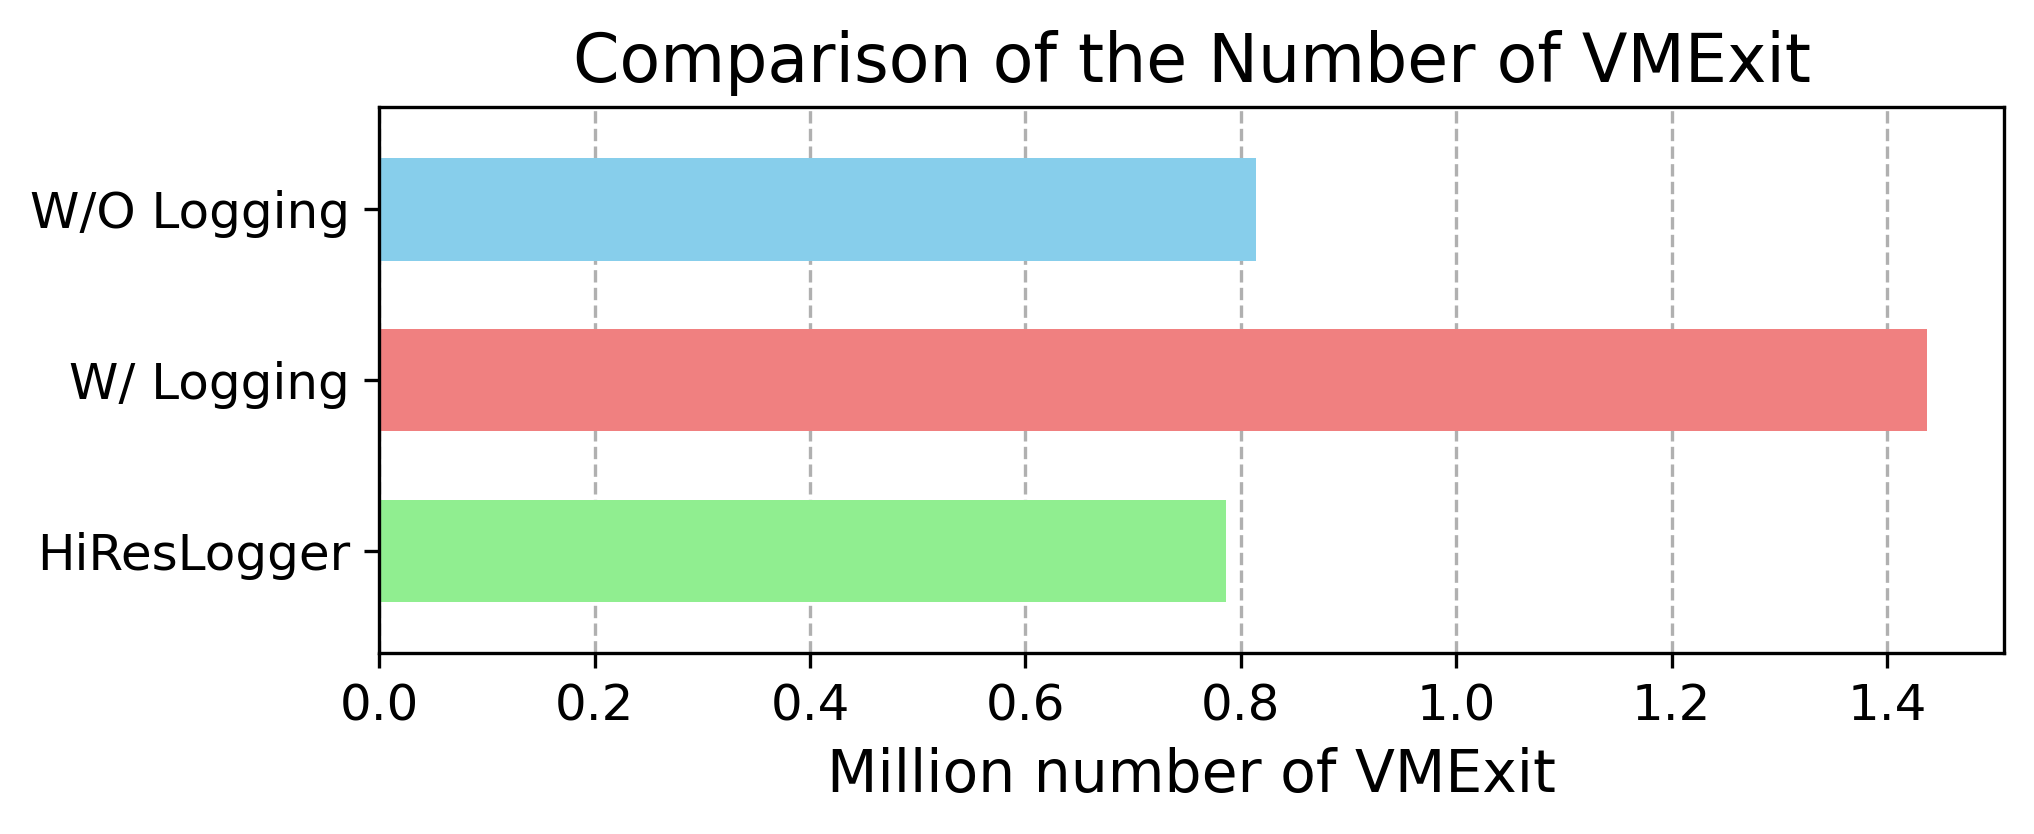

In [31]:
# Data for the plot including HiResLogger
labels_hires = ['W/O Logging', 'W/ Logging', 'HiResLogger']
values_hires = [no_p_20c_2500p, log_20c_2500p, hires_20c_2500p]
colors_hires = ['skyblue', 'lightcoral', 'lightgreen'] # Added a color for HiRes

plt.figure(figsize=(7, 3)) # Adjust figure size for three bars
bars_hires = plt.barh(labels_hires, values_hires, color=colors_hires, height=0.6)

plt.xlabel('Million number of VMExit')
plt.title('Comparison of the Number of VMExit')
plt.gca().invert_yaxis() # Optional: display top bar first

# Add padding to the top and bottom
plt.ylim(len(labels_hires) - 0.5 + 0.1, -0.5 - 0.1) # Adjust limits for padding

plt.grid(True, axis='x', linestyle='--')

# Adjust x-axis limits to make space for labels
plt.xlim(right=max(values_hires) * 1.05) # Add 5% padding to the right

plt.tight_layout()
plt.show()

# HiResLogger